> Atenção: este notebook deve ser executado com ambiente do tipo GPU para uma melhor performance.

In [ ]:
!rm -rf fiap-ml-visao-computacional/

In [ ]:
!git clone https://github.com/FIAPON/fiap-ml-visao-computacional.git

Cloning into 'fiap-ml-visao-computacional'...
remote: Enumerating objects: 65256, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 65256 (delta 1), reused 5 (delta 1), pack-reused 65248 (from 4)
Receiving objects: 100% (65256/65256), 913.26 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (284/284), done.
Updating files: 100% (66601/66601), done.


Vamos agora posicionar o diretório do repositório para a aula respectiva. Nesse caso envie o comando de mudança de diretório.

In [ ]:
%cd fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/

/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado


# 1. Estimativa de Profundidade Monocular



In [ ]:
!pip install timm watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00


In [ ]:
from IPython.display import HTML
from google.colab.output import eval_js
from base64 import b64decode
import io
from PIL import Image
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
import copy as cp

In [ ]:
import watermark

%reload_ext watermark
%watermark -a "Version 0" --iversions

Author: Version 0

PIL       : 11.0.0
torch     : 2.5.1+cu121
IPython   : 7.34.0
google    : 2.0.3
watermark : 2.5.0
numpy     : 1.26.4
matplotlib: 3.8.0
cv2       : 4.10.0



In [ ]:
VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: { deviceId: 1 } })
  .then(stream => video.srcObject = stream)

var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    var ctx = canvas.getContext('2d');
    ctx.drawImage(video, 0, 0, w, h);
    var imageData = ctx.getImageData(0, 0, w, h);
    var dataUrl = canvas.toDataURL('image/jpeg', %f);

    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(dataUrl);
  }
})
</script>
"""

In [ ]:
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
transform = transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0], size[1], quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  img = np.asarray(Image.open(f))

  return img

# Capture a photo using the webcam with deviceId 1
img = take_photo()

In [ ]:
imgbatch = transform(img).to(device)

with torch.no_grad():
    imgbatch = imgbatch.to(device)
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode='bicubic',
        align_corners=False
    ).squeeze()

    output = prediction.cpu().numpy()

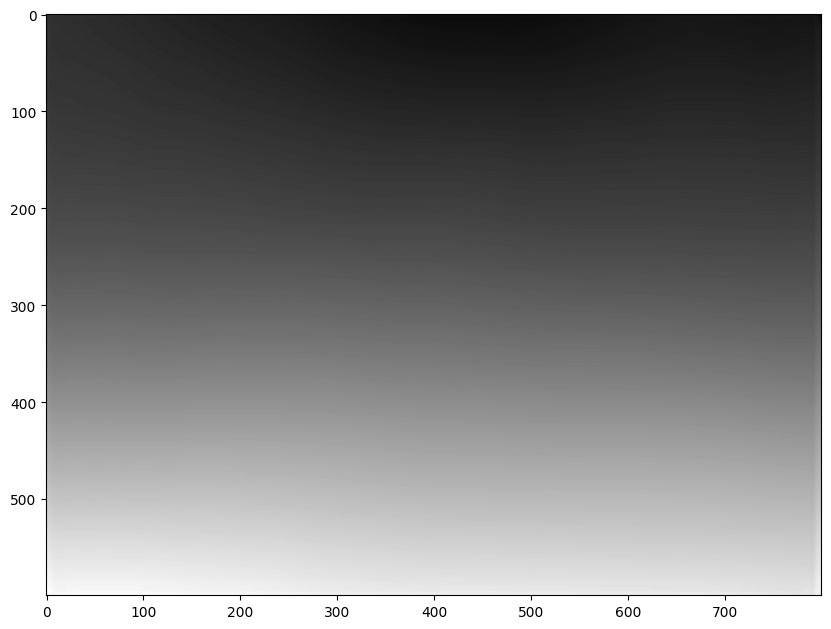

In [ ]:
# Display the captured photo in grayscale
plt.figure(figsize=(10,10))
plt.imshow(output, cmap='gray')
plt.show()

In [ ]:
import requests

def download_image(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()

        with open(save_path, 'wb') as file:
            file.write(response.content)

        print(f"Imagem baixada com sucesso para {save_path}")

    except requests.exceptions.RequestException as e:
        print(f"Erro ao baixar a imagem: {e}")

In [ ]:
image_url = "https://howthingswork.org/wp-content/uploads/2017/05/Cars-down-the-road-e1494988061941.jpg"
save_path = "imagem.jpg"

download_image(image_url, save_path)

Imagem baixada com sucesso para imagem.jpg


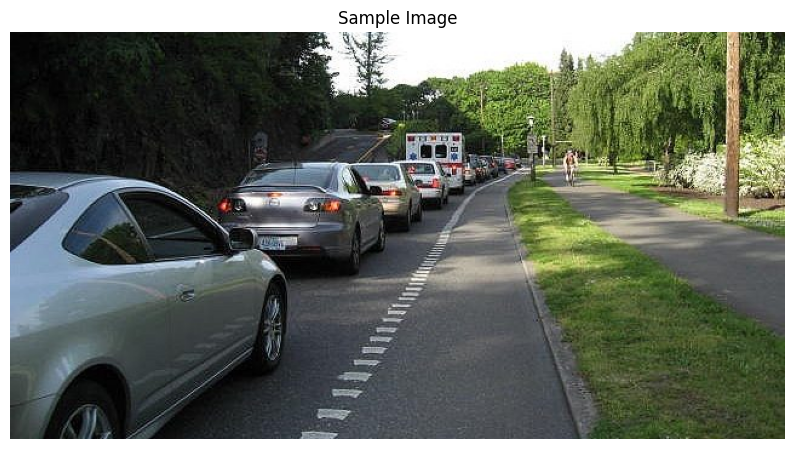

In [ ]:
sample_img = cv2.imread('/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/imagem.jpg')

plt.figure(figsize = [10, 10])

plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [ ]:
imgbatch = transform(sample_img).to(device)

with torch.no_grad():
    imgbatch = imgbatch.to(device)
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=sample_img.shape[:2],
        mode='bicubic',
        align_corners=False
    ).squeeze()

    output = prediction.cpu().numpy()

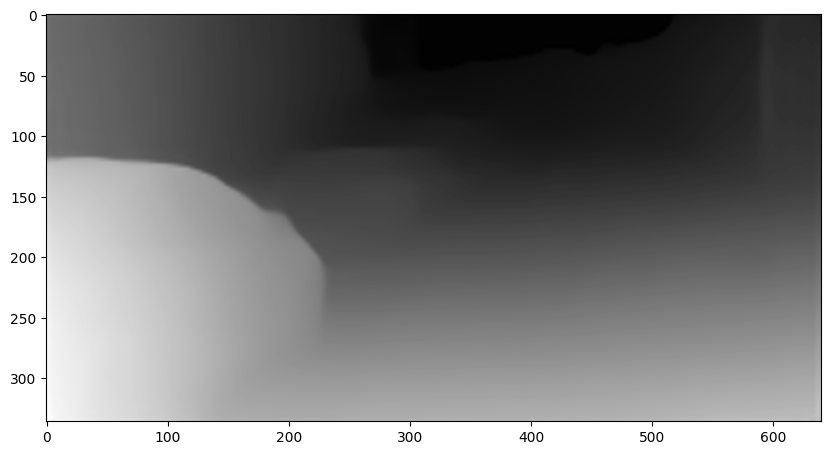

In [ ]:
# Display the captured photo in grayscale
plt.figure(figsize=(10,10))
plt.imshow(output, cmap='gray')
plt.show()

# Faça você mesmo:

Você deve completar o código abaixo que utiliza um modelo de estimativa de profundidade (MiDAS) para dividir a imagem em diferentes camadas de profundidade. Cada camada deve ser visualizada lado a lado, permitindo identificar os diferentes planos de uma cena e explorar como a profundidade é representada.

Para esse exercicio use a imagem `imagens/camara.jpg`.

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


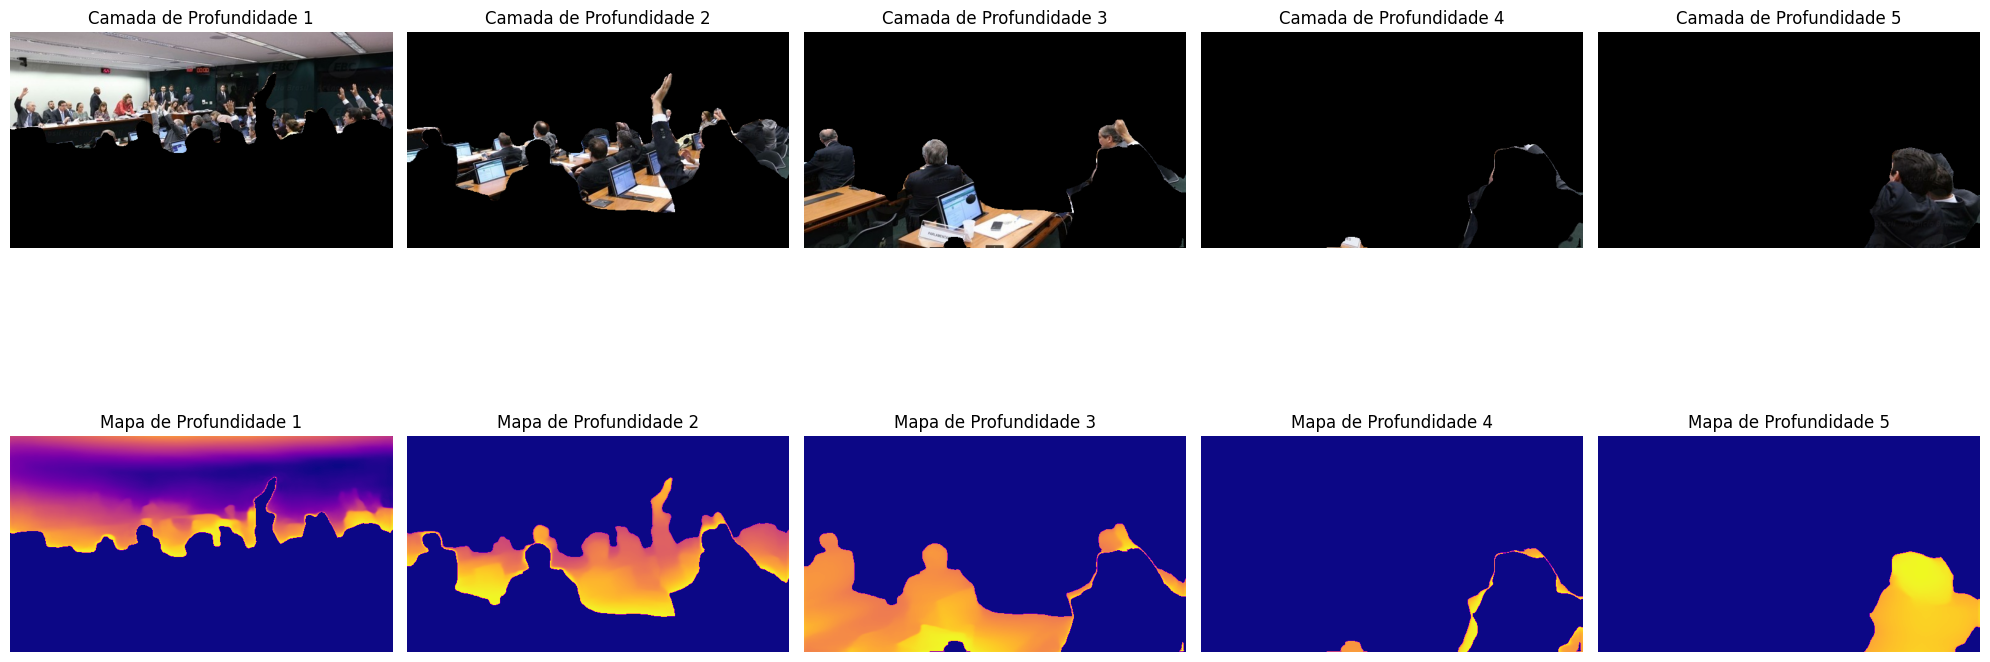

In [ ]:
import torch
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Carregar o modelo MiDaS pré-treinado ("MiDaS_small", "MiDaS_large", "DPT_Large")
model = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
model.eval()

# 1. Carregar uma imagem e processar
# 2. Converta a imagem com os canais de cores corretos
# 3. Extraia a altura e largura da imagem


img = # IMPLEMENTAR
img_rgb = # IMPLEMENTAR
original_height, original_width, _ = # IMPLEMENTAR

# Redimensionar a imagem para a entrada do modelo
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
input_batch = transform(img_rgb).unsqueeze(0)

# Fazer a inferência
with torch.no_grad():
    prediction = model(input_batch)

# Processar o mapa de profundidade para visualização
depth_map = prediction.squeeze().cpu().numpy()
depth_map = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))  # Normalizar entre 0 e 1

# Redimensionar o mapa de profundidade para o tamanho original da imagem
depth_map_resized = cv2.resize(depth_map, (original_width, original_height))

# Definir quantas fatias de profundidade queremos (por exemplo, 5)
num_slices = # IMPLEMENTAR
depth_slices = np.linspace(0, 1, num_slices + 1)

# Visualizar as fatias de profundidade com os mapas correspondentes
plt.figure(figsize=(20, 10))

for i in range(num_slices):
    # Criar a máscara para a faixa de profundidade atual
    mask = (depth_map_resized >= depth_slices[i]) & (depth_map_resized < depth_slices[i + 1])

    # Aplicar a máscara à imagem original
    segmented_image = np.zeros_like(img_rgb)
    segmented_image[mask] = img_rgb[mask]

    # Mostrar a camada de profundidade
    plt.subplot(2, num_slices, i + 1)
    plt.imshow(segmented_image)
    plt.title(f'Camada de Profundidade {i + 1}')
    plt.axis('off')

    # Mostrar o mapa de profundidade correspondente
    depth_segment = np.zeros_like(depth_map_resized)
    depth_segment[mask] = depth_map_resized[mask]
    plt.subplot(2, num_slices, num_slices + i + 1)
    plt.imshow(depth_segment, cmap='plasma')
    plt.title(f'Mapa de Profundidade {i + 1}')
    plt.axis('off')

# Mostrar o layout
plt.tight_layout()
plt.show()


# 2. Detecção de movimento

## Subtratores de Fundo:

Subtratores de fundo são algoritmos comumente usados em visão computacional para detectar objetos em movimento em uma cena. Eles funcionam removendo o fundo estático de uma imagem ou sequência de vídeo, deixando apenas os objetos em movimento. Aqui, o código utiliza dois subtratores de fundo diferentes:

**cv2.createBackgroundSubtractorKNN**: Este é um subtrator de fundo baseado em K-nearest neighbors (KNN). Ele funciona criando um modelo de fundo usando os últimos n frames e classificando cada pixel como pertencente ao primeiro plano (objeto em movimento) ou ao fundo. O algoritmo KNN é usado para determinar a probabilidade de um pixel pertencer ao primeiro plano ou ao fundo.

**cv2.createBackgroundSubtractorMOG2**: Este é um subtrator de fundo baseado em Mixture of Gaussians (MOG2). Ele modela cada pixel da imagem como uma mistura de várias distribuições gaussianas. Pixels que têm uma probabilidade baixa de pertencer ao modelo de fundo são considerados parte do primeiro plano. O modelo é atualizado ao longo do tempo para se adaptar a mudanças na cena.

Ambos os subtratores de fundo são usados para criar uma máscara que destaca as áreas em movimento em relação ao fundo estático. Essas máscaras são posteriormente usadas para identificar e rastrear objetos em movimento na cena.

## 2.1 Fluxo Óptico

In [ ]:
import cv2
import numpy as np
import os
from google.colab import files


In [ ]:
# Caminho para o vídeo
video_path = "videos/people_walk.mp4"
output_path_combined = "output_video_combined.avi"

In [ ]:
# Carregar o vídeo
cap = cv2.VideoCapture(video_path)

In [ ]:
# Obter as dimensões do quadro
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))


In [ ]:
# Ajustar a resolução do vídeo processado
resize_width = 640
resize_height = 360

#### `cv2.createBackgroundSubtractorMOG2`

Esta função cria um objeto de subtração de fundo baseado no algoritmo MOG2. Ela é amplamente utilizada para detecção de movimento em vídeos. Abaixo estão os principais parâmetros:

1. **`history`**
   - **Descrição**: Número de quadros utilizados para modelar o background.
   - **Impacto**:
     - Valores maiores tornam o modelo de fundo mais estável, porém menos responsivo a mudanças rápidas.
     - Valores menores fazem com que o modelo se adapte mais rapidamente a alterações, mas podem incluir falsos positivos.
   - **Exemplo**: `history=500` utiliza 500 quadros para modelar o background.

2. **`varThreshold`**
   - **Descrição**: Limiar para decisão de se um pixel pertence ao background ou foreground.
   - **Impacto**:
     - Valores baixos aumentam a sensibilidade, capturando mais detalhes (inclusive ruídos).
     - Valores altos ignoram pequenas variações, como leves alterações de iluminação.
   - **Exemplo**: `varThreshold=16` define um nível moderado de sensibilidade.

3. **`detectShadows`**
   - **Descrição**: Habilita (`True`) ou desabilita (`False`) a detecção de sombras.
   - **Impacto**:
     - Quando ativado, o algoritmo detecta sombras e as marca com valores intermediários na máscara (geralmente cinza).
     - Isso é útil para separar sombras de objetos em movimento.
   - **Exemplo**: `detectShadows=True` ativa a detecção de sombras.

#### Ajustando os Parâmetros
- **Cenários com movimentos rápidos**: Reduza o `history` para que o modelo se adapte rapidamente.
- **Cenários com iluminação variável**: Aumente o `varThreshold` para evitar falsos positivos.
- **Ambientes com muitas sombras**: Mantenha `detectShadows=True` para melhorar a precisão da detecção.

Se precisar de um exemplo prático ou uma configuração específica, posso ajudar!```


In [ ]:
# Criar o objeto para subtração de fundo
back_sub_mog2 = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)

#### `cv2.createBackgroundSubtractorKNN`

A função `cv2.createBackgroundSubtractorKNN` cria um objeto para subtração de fundo utilizando o algoritmo KNN (K-Nearest Neighbors). Este método é eficiente para detectar movimento em vídeos com menor variação no background.

#### Parâmetros

1. **`history`**
   - **Descrição**: Número de quadros utilizados para modelar o background.
   - **Impacto**:
     - Valores maiores criam um modelo de fundo mais estável, mas menos adaptável a mudanças rápidas.
     - Valores menores tornam o modelo mais dinâmico, mas podem introduzir falsos positivos.
   - **Exemplo**: `history=500` define que 500 quadros serão usados para modelar o fundo.

2. **`dist2Threshold`**
   - **Descrição**: Distância euclidiana ao quadrado que define se um pixel deve ser classificado como foreground ou background.
   - **Impacto**:
     - Valores baixos tornam o algoritmo mais sensível a mudanças pequenas.
     - Valores altos ignoram pequenas alterações, como leves mudanças de iluminação.
   - **Exemplo**: `dist2Threshold=400.0` utiliza uma sensibilidade moderada.

3. **`detectShadows`**
   - **Descrição**: Habilita (`True`) ou desabilita (`False`) a detecção de sombras.
   - **Impacto**:
     - Quando ativado, sombras são identificadas e marcadas com valores intermediários na máscara (geralmente cinza).
   - **Exemplo**: `detectShadows=True` permite a identificação de sombras para melhorar a precisão.

#### Ajustes Típicos
- Para ambientes com muitas sombras, mantenha `detectShadows=True`.
- Para cenários com movimentos rápidos, reduza o valor de `history`.
- Ajuste o `dist2Threshold` conforme a sensibilidade necessária para diferenciar foreground de background.

#### Comparação com MOG2
- **Vantagem**: KNN é mais robusto em cenários com baixa variação de iluminação.
- **Desvantagem**: Pode ser mais lento em comparação ao MOG2 para grandes vídeos.

Se precisar de exemplos ou ajustes detalhados para um cenário específico, posso ajudar!```


In [ ]:
back_sub_knn = cv2.createBackgroundSubtractorKNN(history=500, dist2Threshold=400.0, detectShadows=True)

In [ ]:
# Configurar o gravador de vídeo
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_combined = cv2.VideoWriter(output_path_combined, fourcc, fps, (resize_width * 3, resize_height))


In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Reduz a resolução para processamento mais rápido
    frame_resized = cv2.resize(frame, (resize_width, resize_height))

    # Aplicar os subtratores de fundo
    fg_mask_mog2 = back_sub_mog2.apply(frame_resized)
    fg_mask_knn = back_sub_knn.apply(frame_resized)

    # Melhorar as máscaras binárias (opcional)
    fg_mask_mog2 = cv2.medianBlur(fg_mask_mog2, 5)  # Reduz ruídos pequenos
    fg_mask_knn = cv2.medianBlur(fg_mask_knn, 5)

    # Converter as máscaras para 3 canais para combinar com o quadro original
    fg_mask_mog2_bgr = cv2.cvtColor(fg_mask_mog2, cv2.COLOR_GRAY2BGR)
    fg_mask_knn_bgr = cv2.cvtColor(fg_mask_knn, cv2.COLOR_GRAY2BGR)

    # Encontrar contornos nos objetos detectados para MOG2
    contours_mog2, _ = cv2.findContours(fg_mask_mog2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours_mog2:
        if cv2.contourArea(contour) > 500:  # Filtra pequenos movimentos
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(frame_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Encontrar contornos nos objetos detectados para KNN
    contours_knn, _ = cv2.findContours(fg_mask_knn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours_knn:
        if cv2.contourArea(contour) > 500:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(frame_resized, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Concatenar os quadros originais, MOG2 e KNN lado a lado
    combined_frame = cv2.hconcat([frame_resized, fg_mask_mog2_bgr, fg_mask_knn_bgr])

    # Gravar o quadro no vídeo de saída combinado
    out_combined.write(combined_frame)

# Liberar recursos
cap.release()
out_combined.release()

print(f"Vídeo processado salvo em: {output_path_combined}")

Vídeo processado salvo em: output_video_combined.avi


# Faça você mesmo:

O objetivo deste exercício é implementar um algoritmo capaz de detectar movimentos em um vídeo utilizando técnicas de visão computacional com a biblioteca OpenCV. Além de realizar a detecção, você irá exportar o vídeo processado para análise posterior.

Para esse exercicio utilize o video `videosvideos/cars.mp4`

### Contexto

Detecção de movimento é uma aplicação fundamental de visão computacional, utilizada em sistemas de segurança, monitoramento de tráfego, análise esportiva, entre outros. Neste exercício, você utilizará a técnica de subtração de fundo (background subtraction) para identificar regiões onde ocorrem movimentos em um vídeo fornecido.


In [ ]:
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow

# Carregar o vídeo
cap = # IMPLEMENTAR

# Obter o número total de quadros para a barra de progresso
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Obter o tamanho e FPS do vídeo original
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Configurar o objeto de escrita de vídeo
out = cv2.VideoWriter('/content/output_video.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (640, 360))

# Criar o objeto de subtração de fundo
fgbg = # IMPLEMENTAR

# Inicializar a barra de progresso
with tqdm(total=total_frames, desc="Processando vídeo") as pbar:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Reduz o tamanho do quadro (opcional, para melhorar a performance)
        frame = cv2.resize(frame, (640, 360))

        # Aplica a subtração de fundo
        fgmask = fgbg.apply(frame)

        # Destacar as áreas de movimento (use findContours)
        contours, _ = # IMPLEMENTAR
        for contour in contours:
            # IMPLEMENTAR

        # Escrever o quadro processado no vídeo de saída
        out.write(frame)

        # Atualizar a barra de progresso
        pbar.update(1)

cap.release()
out.release()  # Finalizar a escrita do vídeo

print("Vídeo processado e salvo como '/content/output_video.avi'")


## 3. Deep learning a classificação de imagens

Para criar um modelo de Deep Learning para reconhecimento de imagens utilizando o conjunto de dados [COIL-100](https://www.kaggle.com/datasets/jessicali9530/coil100) da Columbia Object Image Library.

![](https://github.com/michelpf/fiap-ml-visao-computacional/blob/master/aula-5-machine-learning-aplicado/imagens/coil100.jpg?raw=true)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import datetime

from os import listdir
from os.path import isfile, join, isdir, sep

from tqdm import tqdm

# Scikit learn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Tensorflow
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras import optimizers

import tensorflow as tf

sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
!rm -rf dataset-coil-100-adapted/

In [ ]:
!git clone https://github.com/michelpf/dataset-coil-100-adapted

Cloning into 'dataset-coil-100-adapted'...
remote: Enumerating objects: 7315, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 7315 (delta 2), reused 2 (delta 2), pack-reused 7312
Receiving objects: 100% (7315/7315), 124.11 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (5/5), done.


### 3.1 Identificando as classes

Como um gerador de captchas nem sempre explora todo o alfabeto, vamos identificar exatamente quais as letras são utilizadas para listar todas as possíveis classes deste problema.

In [ ]:
pasta_imagens_treino = "dataset-coil-100-adapted/dataset"
lista_arquivos_classes = [f for f in listdir(pasta_imagens_treino) if isdir(join(pasta_imagens_treino, f))]

lista_classes = list(set(lista_arquivos_classes))
print(lista_classes)
print(len(lista_classes))

['fruit-chewing-gum', 'correction-fluid-red', 'coke', 'alien-toy', 'bulb-plug', 'orange-flower-cup', 'cigarette-box-paramont', 'red-pepper', 'frog-toy', 'pain-relief-dristan', 'iced-tea', 'floater', 'red-sport-car', 'small-shovel', 'floss-waxed', 'teapot', 'men-deodorant', 'japanese-cup', 'scotch-tape', 'red-sport-car-toy', 'strawberry', 'tiny-vase', 'yellow-pot', 'hook', 'orange-soda', 'wood-triangle-piece', 'pain-relief-tylenol', 'baby-powder', 'flower-coffee-cup', 'flower-cup', 'canada-dry-soda', 'fishing-boat-toy', 'fire-department-truck-toy', 'truck-sport-car', 'wood-piece-rectangular-toy', 'sport-car-toy', 'white-sport-car', 'chicken-spice', 'beef-bouillon', 'yellow-racing-car-toy', 'piggy-bank', 'boat-toy', 'plate', 'cinnamon', 'rubber-duck', 'yoyo', 'tomato', 'sandwich', 'chewing-gum', 'red-pot', 'red-floater', 'vaseline', 'onion', 'old-flower-cup', 'pain-relief-anacin', 'vase', 'cream-cheese', 'wood-toy', 'truck-toy', 'cheeseburger', 'racing-toy', 'blue-boat-toy', 'soap-cup', 

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.3, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "dataset-coil-100-adapted/dataset",
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb',
    target_size=(128, 128),
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    "dataset-coil-100-adapted/dataset",
    class_mode="categorical",
    color_mode='rgb',
    target_size=(128, 128),
    subset='validation')

Found 5100 images belonging to 100 classes.
Found 2100 images belonging to 100 classes.


### 3.2 Treinamento

Colecionando imagens para treinamento e realizando pequenos ajustes para posterior uso na biblioteca de deep-learning do Keras.

Ao todo temos as seguintes quantidades de exemplos:

Vamos também simplificar a informação de escala de cinza. Utilizaremos a forma normalizada, dividindo todos os valores por 255. Desta forma um pixel 100% branco seria 1, e outro 100% preto seria 0.

Realizando a divisão de treinamento e validação.

### 3.3 Arquitetura

Partimos de um modelo simples que na maioria das vezes resolve problemas de OCR como esse. Como foi citado, identificações mais complexas utilizamos outras aboragens ou evolução de uma arquitetura inicial como esta.

In [ ]:
# Construindo um modelo sequencial
model = Sequential()

# Este componente, se trata de um filtro ou uma camada convulacional. Ela será responsável por
# colocar uma janela de kernel, navegar pela imagem e extrair a soma dos pixels de cada janela
# o passo para mover a janela, chamado Stride, por padrão é de um pixel
model.add(Conv2D(10, kernel_size=(3, 3), input_shape=(128, 128, 3), activation="relu"))

# A camada de Pooling (ou MaxPooling2D) tem o papel de reduzir a dimensionalidade. Neste caso, a partir
# da etapa anterior, será dividia em grupos de 2 x 2 pixels e será obtida o maior valor deles
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(10, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# O Dropout é um ruído gerado para evitar overfitting
model.add(Dropout(0.2))

# Esta etapa conhecida como "achatamento" é onde abrimos os dados organizados em tabelas (ou matrizes)
# para uma única linha
model.add(Flatten())

# A camada densa (ou Dense) conectará cada elemento da camada anterior e passará para a próxima
# camada com as classes existentes
model.add(Dense(128, activation="relu"))

# A camada final, determinará qual classe escolher. Por tal razão ela possui a ativação Softmax, que retorna
# a probabilidade por classe
model.add(Dense(100, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 10)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 30, 10)        0         
                                                                 
 flatten (Flatten)           (None, 9000)              0

In [ ]:
!pip install visualkeras==0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 18.4 MB/s eta 0:00:00


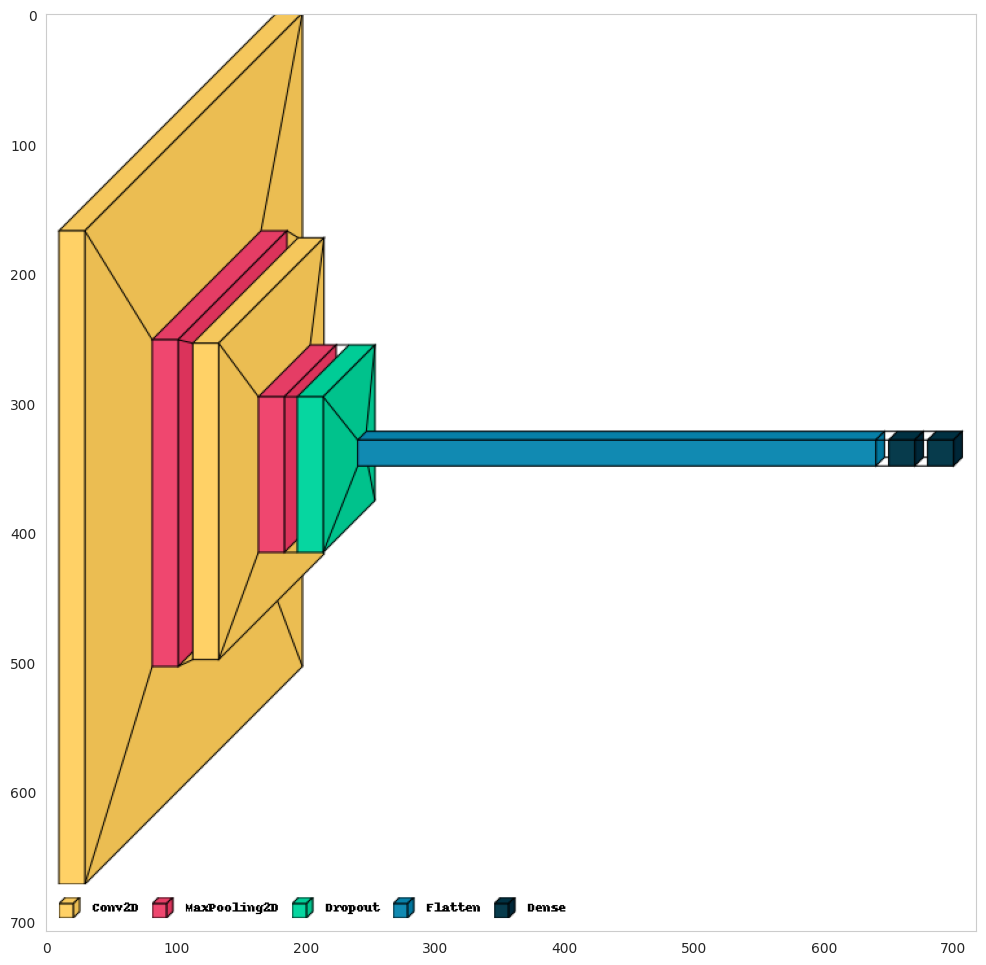

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True, to_file="graph.png")

image = cv2.imread("graph.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,30))
plt.imshow(image)

In [ ]:
!pip install keras-vis==0.4.1

Trecho abaixo ajustado do [Kaggle](https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn/notebook) de Arpit Jain.

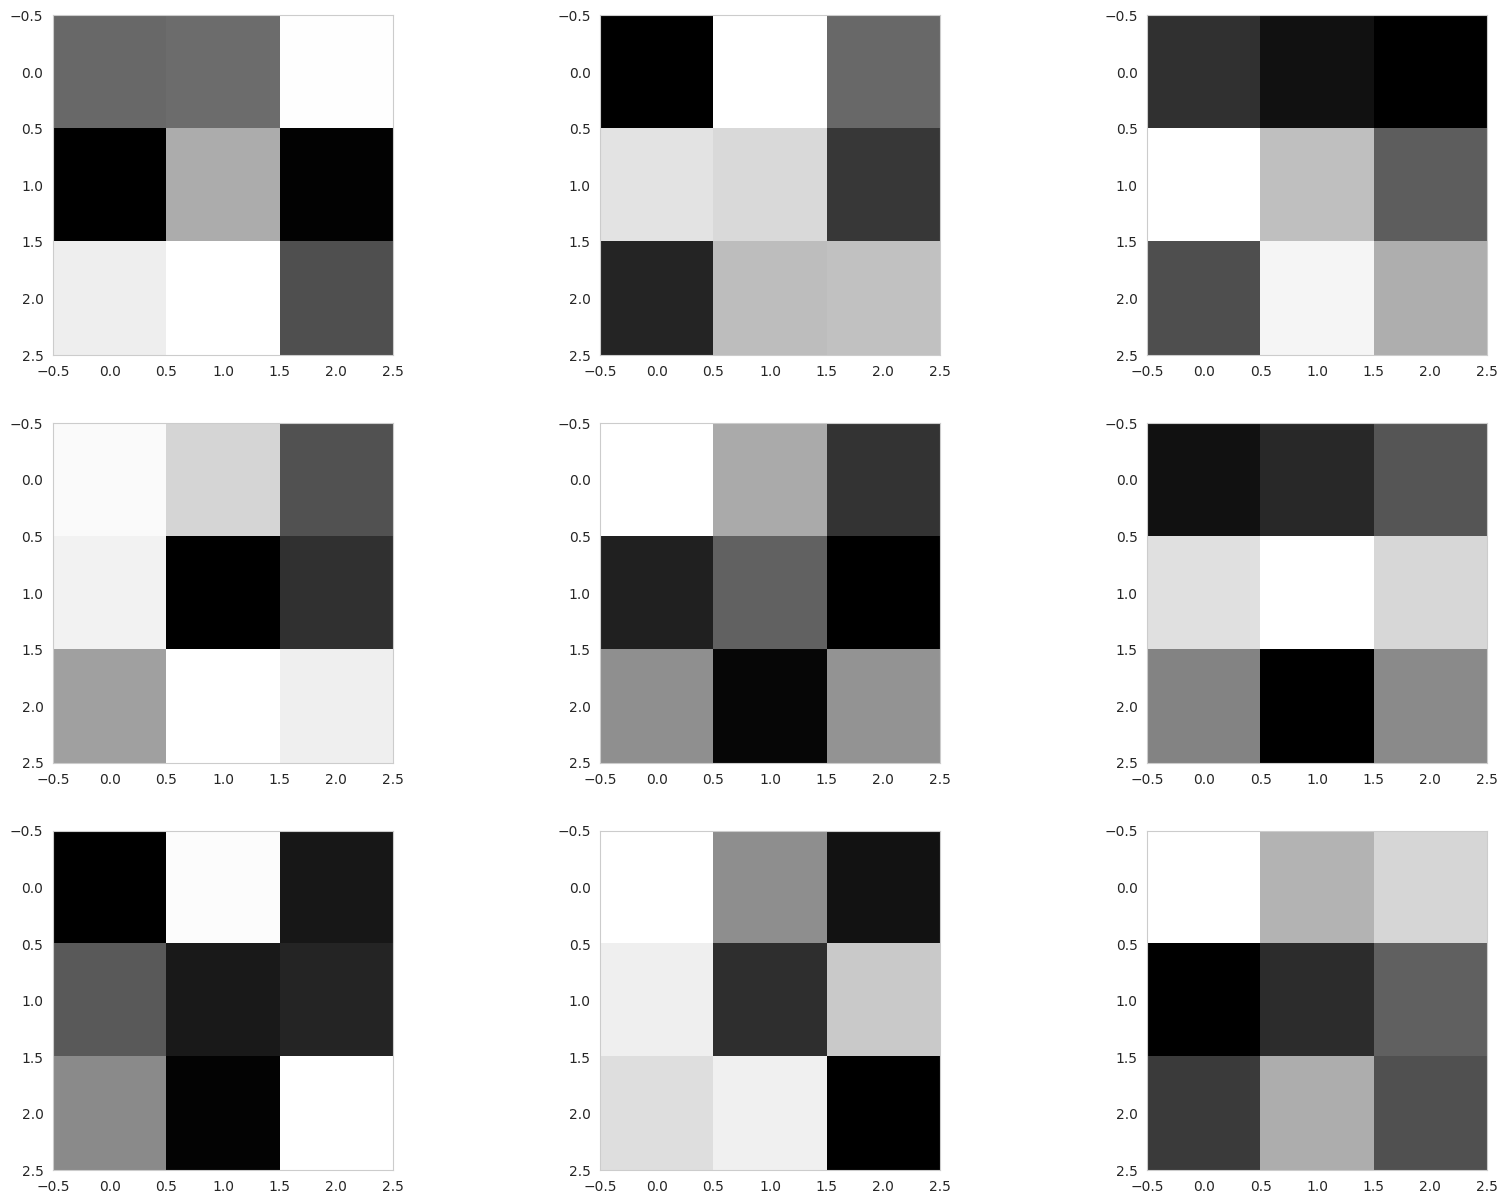

In [ ]:
filters , bias = model.layers[0].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 3
ix=1

fig = plt.figure(figsize=(20,15))

for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1


#plot the filters
plt.show()


In [ ]:
model.layers[0]

Para revisão de funções de ativação, em particular [Relu](https://matheusfacure.github.io/2017/07/12/activ-func/).

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=3)

Epoch 1/3
160/160 [==============================] - 30s 159ms/step - loss: 2.9478 - accuracy: 0.5057 - val_loss: 0.8345 - val_accuracy: 0.7895
Epoch 2/3
160/160 [==============================] - 11s 67ms/step - loss: 0.1401 - accuracy: 0.9590 - val_loss: 0.4902 - val_accuracy: 0.8557
Epoch 3/3
160/160 [==============================] - 11s 67ms/step - loss: 0.0385 - accuracy: 0.9902 - val_loss: 0.4653 - val_accuracy: 0.8795


Os gráficos a seguir mostram convergência de acurácia para os dados de treinamento e validação.
Note que o valor do erro, diferentemente da acurácia, não é expressada em porcentagem, portanto erro < 1 é um ótimo valor.

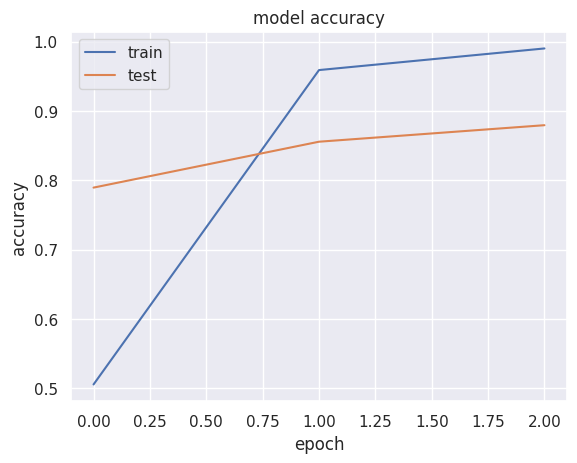

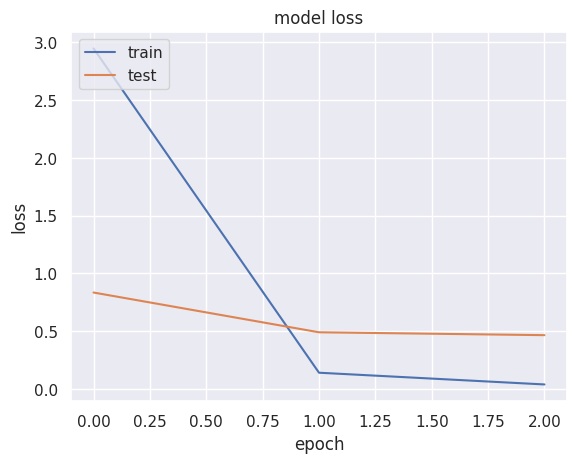

In [ ]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Salvando o modelo para uso posterior. Mesmo imagens pequenas como essas levam vários minutos para treinar.

In [ ]:
!mkdir pesos

In [ ]:
# Salvando o modelo no formato HDf5
model.save("modelos/model.h5")

# Arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights("pesos/weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Uma vez salvo o modelo, nesta etapa é só carregar.

In [ ]:
# carregando o modelo no formato HDf5
model = load_model("modelos/model.h5")
model.load_weights("pesos/weights.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 10)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 30, 10)        0         
                                                                 
 flatten (Flatten)           (None, 9000)              0

### 3.4 Testes de validação
Vamos inferir algumas imagens para verificar visualmente como o classificador está se comportando.
Para isso definimos uma função para normalizar uma imagem do captcha, para extrair os ruídos e posteriomente cada uma das suas letras.

Execução da função. Neste caso não fizemos a inversão da imagem pois as letras foram treinadas com o fundo branco.

In [ ]:
imagens_teste_path = ["dataset-coil-100-adapted/dataset/alien-toy/20.png",
                      "dataset-coil-100-adapted/dataset/telephone/20.png",
                      "dataset-coil-100-adapted/dataset/cheeseburger/20.png"
                      ]

lista_imagem = []

for imagem_path in imagens_teste_path:
    imagem = cv2.imread(imagem_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (128, 128))
    lista_imagem.append(imagem)

lista_imagem_array = np.array(lista_imagem, dtype="float")
lista_imagem_array = preprocess_input(lista_imagem_array)

In [ ]:
pred_probs = model.predict(lista_imagem_array)
y_classes = pred_probs.argmax(axis=-1)

1/1 [==============================] - 0s 183ms/step


In [ ]:
classes_labels = train_generator.class_indices
key_list = list(classes_labels.keys())
val_list = list(classes_labels.values())

In [ ]:
key_list[val_list[y_classes[0]]]

'alien-toy'

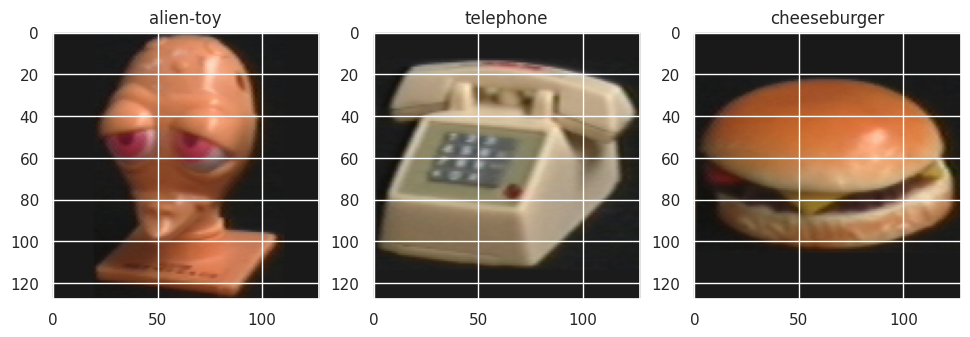

In [ ]:
plt.figure(figsize=(20,10))

for i, imagem in enumerate(lista_imagem):
    plt.subplot(1,5,i+1)
    plt.imshow(imagem)
    plt.title("{}".format(key_list[val_list[y_classes[i]]]))

plt.show()

Agora vamos investigar quais foram as regiões que foram mais atividadas, sendo por sua vez as mais relevantes e com a qual o modelo aprendeu mais. Isso é importante para evitarmos que os nossos modelos aprendam com as características erradas. Um bom exemplo é quando o modelo aprende a classificar uma girafa pelo backgroud árido das savana africanas.

Para a evidenciação destas regiões utilizamos a técnica GradCam, oriundo deste [paper](https://arxiv.org/abs/1610.02391) de Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra.

## 4. Transfer learning para reconhecimento de imagens

Técnica de transfer learning aplicado a deep learnig para classificação de imagens, utilizando classificados com pesos já treinados disponibilizados no Keras.

Foram utilizadas imagens representado dígitos de 0 a 9 com 500 imagens de cada uma, ao todo 5000 imagens.

As imagens de treinamento possuem 400 x 400 de resolução com 3 canais (imagens coloridas representadas em BGR ou RGB).

### 4.1 Geradores de imagens

Conjunto de dados utilizado foi [American Sign Language Digit Dataset](https://www.kaggle.com/rayeed045/american-sign-language-digit-dataset), disponível no Kaggle.

Os geradores utilizados foram aplicados para converter o tamanho adequado do modelo utilizado (224 x 224 pixels) como também para criar novos exemplos a partir das imagens no que chamamos de _data augmentation_, por meio de perturbações da imagem baseado em recorte (```shear```), zoom e orientação horizontal (```horizontal_flip```).

Com a técnica de data augmentation ainda é possível crescer o número de imagens de treinamento ao incorporar as distorções citadas.

In [ ]:
!rm -rf dataset-american-sign-language-digit/

In [ ]:
!git clone https://github.com/michelpf/dataset-american-sign-language-digit

Cloning into 'dataset-american-sign-language-digit'...
remote: Enumerating objects: 4619, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4619 (delta 1), reused 9 (delta 1), pack-reused 4610
Receiving objects: 100% (4619/4619), 111.48 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (5001/5001), done.


In [ ]:
imagem = cv2.imread("dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg")
imagem.shape

(400, 400, 3)

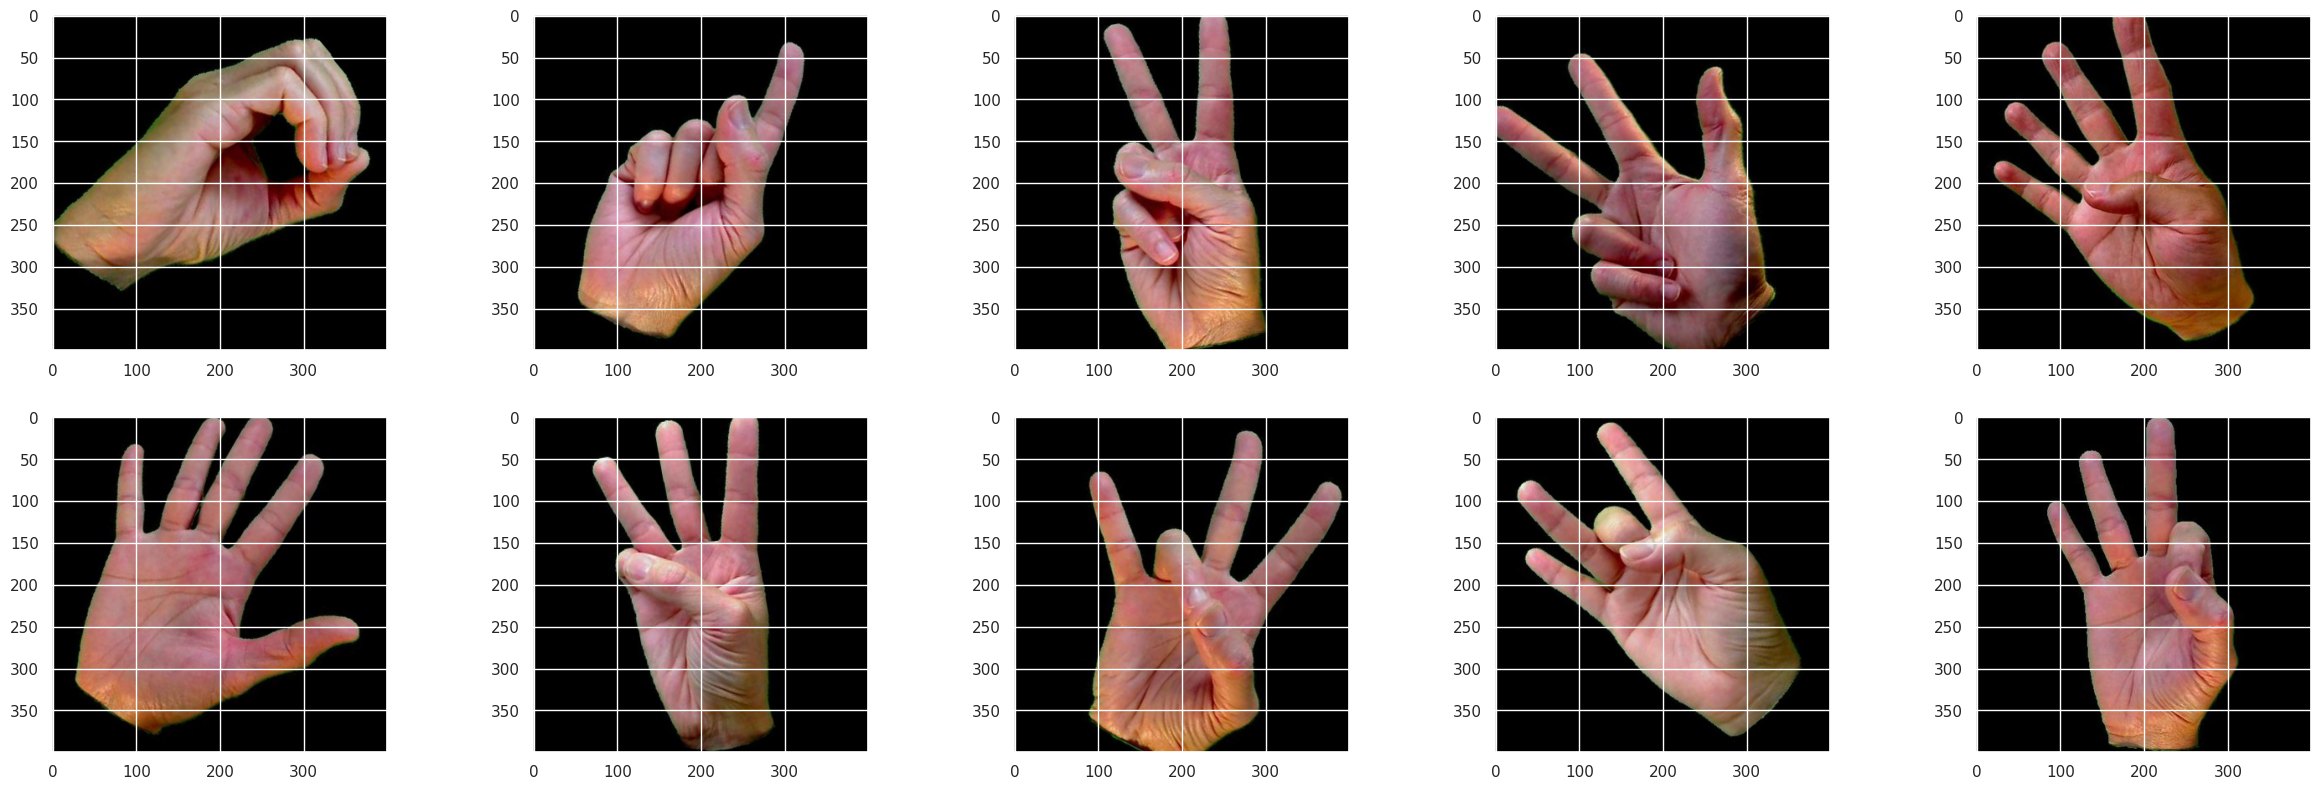

In [ ]:
# Exibição das imagens
img1 = cv2.imread("dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("dataset-american-sign-language-digit/dataset/1/Sign 1 (2).jpeg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread("dataset-american-sign-language-digit/dataset/2/Sign 2 (3).jpeg")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.imread("dataset-american-sign-language-digit/dataset/3/Sign 3 (4).jpeg")
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.imread("dataset-american-sign-language-digit/dataset/4/Sign 4 (5).jpeg")
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.imread("dataset-american-sign-language-digit/dataset/5/Sign 5 (6).jpeg")
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
img7 = cv2.imread("dataset-american-sign-language-digit/dataset/6/Sign 6 (8).jpeg")
img7 = cv2.cvtColor(img7, cv2.COLOR_BGR2RGB)
img8 = cv2.imread("dataset-american-sign-language-digit/dataset/7/Sign 7 (9).jpeg")
img8 = cv2.cvtColor(img8, cv2.COLOR_BGR2RGB)
img9 = cv2.imread("dataset-american-sign-language-digit/dataset/8/Sign 8 (10).jpeg")
img9 = cv2.cvtColor(img9, cv2.COLOR_BGR2RGB)
img10 = cv2.imread("dataset-american-sign-language-digit/dataset/9/Sign 9 (11).jpeg")
img10 = cv2.cvtColor(img10, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))

plt.subplot(4,5,1)
plt.imshow(img1)
plt.subplot(4,5,2)
plt.imshow(img2)
plt.subplot(4,5,3)
plt.imshow(img3)
plt.subplot(4,5,4)
plt.imshow(img4)
plt.subplot(4,5,5)
plt.imshow(img5)
plt.subplot(4,5,6)
plt.imshow(img6)
plt.subplot(4,5,7)
plt.imshow(img7)
plt.subplot(4,5,8)
plt.imshow(img8)
plt.subplot(4,5,9)
plt.imshow(img9)
plt.subplot(4,5,10)
plt.imshow(img10)

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "dataset-american-sign-language-digit/dataset",
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb',
    target_size=(224,224),
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    "dataset-american-sign-language-digit/dataset",
    class_mode="categorical",
    color_mode='rgb',
    target_size=(224,224),
    subset='validation')

Found 3500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


Exibindo as classes identificadas.

In [ ]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

### 5.2 Construindo a rede neural baseado em modelo pré-treinado

O Keras já possui classes especializadas para os seguintes modelos de deep-learning treinados com o conjunto de dados [ImageNet](http://www.image-net.org/):
  
* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet
* MobileNetV2

Mais detalhes, veja na [documentação do Keras](https://keras.io/applications/).

_O Keras se encarrega de baixar o modelo automaticamente, não é preciso baixar separadamente._

Note que o parâmetro ```include_top=False``` configura o modelo para não utilizar a camada densa original, pois será substituída pelas novas classes.

In [ ]:
conv_base = VGG19(include_top=False)

for layer in conv_base.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


Removendo a camada densa para que seja adaptada para lidar com apenas 2 classes.

In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)
model = Model(conv_base.input, predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 5.3 Treinamento do modelo

In [ ]:
history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
110/110 [==============================] - 70s 623ms/step - loss: 1.0540 - accuracy: 0.6600 - val_loss: 0.6545 - val_accuracy: 0.7660
Epoch 2/5
110/110 [==============================] - 69s 630ms/step - loss: 0.2816 - accuracy: 0.9214 - val_loss: 0.4740 - val_accuracy: 0.8273
Epoch 3/5
110/110 [==============================] - 69s 624ms/step - loss: 0.1632 - accuracy: 0.9609 - val_loss: 0.3595 - val_accuracy: 0.8773
Epoch 4/5
110/110 [==============================] - 68s 618ms/step - loss: 0.1181 - accuracy: 0.9709 - val_loss: 0.3311 - val_accuracy: 0.8840
Epoch 5/5
110/110 [==============================] - 68s 621ms/step - loss: 0.0811 - accuracy: 0.9811 - val_loss: 0.2920 - val_accuracy: 0.9047


Armazenamento do modelo e carregamento do modelo pré-treinado.

In [ ]:
# salvando o modelo no formato HDf5
model.save('modelos/modelo-sign.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights('modelos/weights-sign.h5')
with open('modelos/architecture-sign.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
# carregando o modelo no formato HDf5
model = load_model('modelos/modelo-sign.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
with open('modelos/architecture-sign.json') as f:
    model = model_from_json(f.read())

model.load_weights('modelos/weights-sign.h5')

### 4.4 Predição nas imagens de teste

In [ ]:
imagens_teste_path = ["dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/1/Sign 1 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/2/Sign 2 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/3/Sign 3 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/4/Sign 4 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/5/Sign 5 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/6/Sign 6 (20).jpeg",
                      "dataset-american-sign-language-digit/dataset/7/Sign 7 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/8/Sign 8 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/9/Sign 9 (1).jpeg"]

lista_imagem = []

for imagem_path in imagens_teste_path:
    imagem = cv2.imread(imagem_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (224, 224))
    lista_imagem.append(imagem)

In [ ]:
lista_imagem_array = np.array(lista_imagem, dtype="float")
lista_imagem_array = preprocess_input(lista_imagem_array)

Normalizando as imagens de teste, como neste caso não usamos o gerador do Keras, precisamos ajustar manualmente.

In [ ]:
pred_probs = model.predict(lista_imagem_array)
probs = pred_probs.max(1)
probs

1/1 [==============================] - 0s 156ms/step


array([0.9974009 , 0.97561055, 0.9905347 , 0.9997756 , 0.99167836,
       0.9683867 , 0.99842036, 0.93980384, 0.9878812 , 0.9263951 ],
      dtype=float32)

In [ ]:
y_classes = pred_probs.argmax(axis=-1)
y_classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<ipython-input-58-f34603061d6c>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i+1)


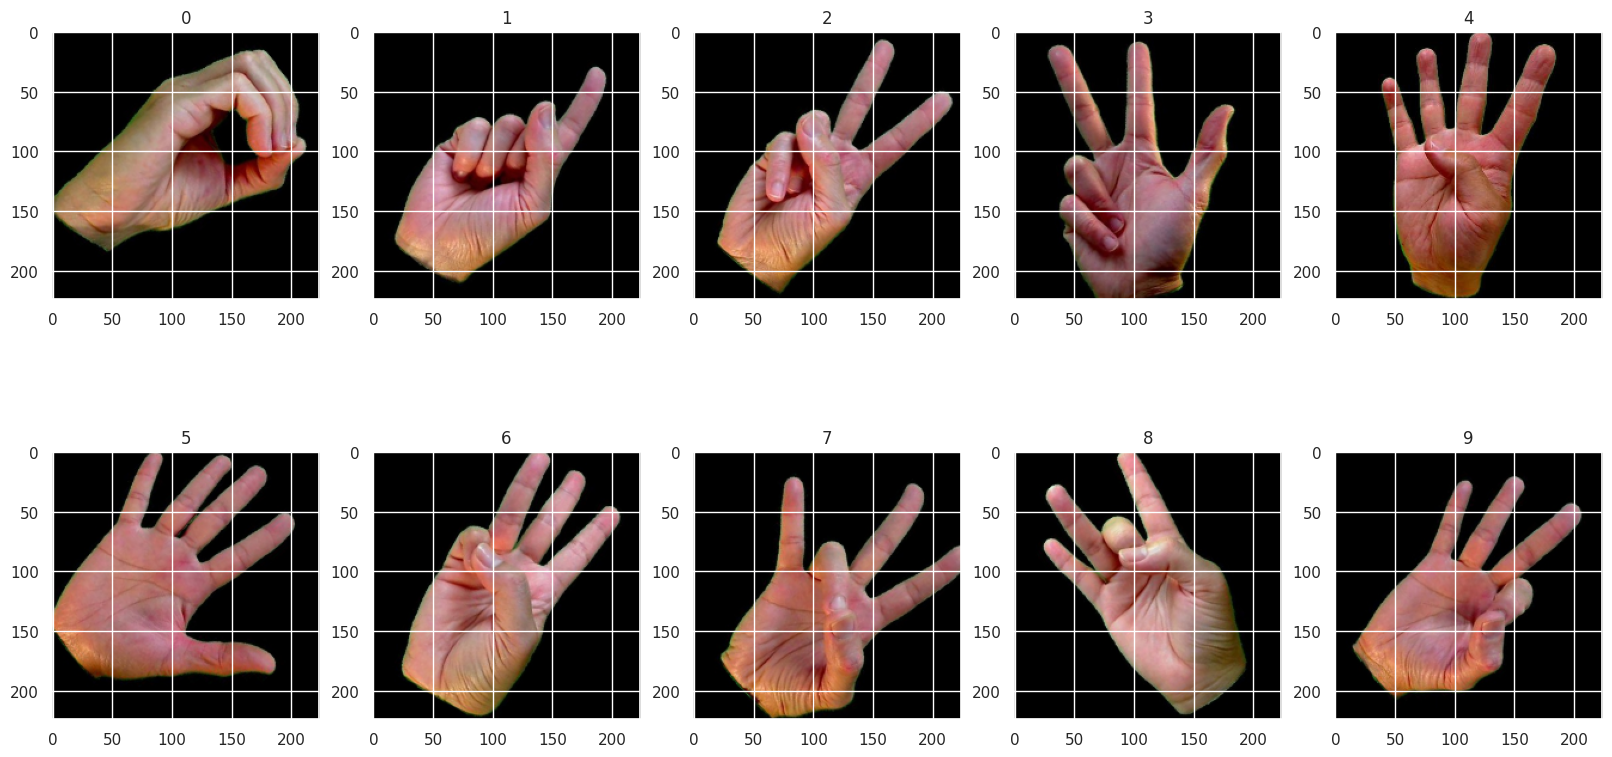

In [ ]:
plt.figure(figsize=(20,10))
plt.axis('off')
plt.grid(False)

for i, imagem in enumerate(lista_imagem):
    plt.subplot(2,5,i+1)
    plt.imshow(imagem)
    plt.title("{}".format(y_classes[i]))

plt.show()

## 5. Classificador de Objetos

Para a classificação de objetos iremos utilizar o modelo considerado o mais avançado, preciso e rápido da atualidade, que é a família YOLO (You Only Look Once).

O modelo YOLOv8 é o mais novo estado-da-arte para detecção de objetos, classificação de imagens e tarefas de segmentação de instâncias. O YOLOv8 foi desenvolvido pela Ultralytics, que também criou o influente e definidor de padrões da indústria, modelo YOLOv5. O YOLOv8 inclui várias mudanças arquiteturais e melhorias na experiência de desenvolvedor em relação ao YOLOv5.

### 5.1 Implementação

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.6/922.6 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import ultralytics
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Validando se todas as configurações e GPU foram detectadas com sucesso.

In [ ]:
ultralytics.checks()

Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.0/112.6 GB disk)


Uma forma de realizar as predições é utilizando a biblioteca diretamente. Neste caso precisamos instanciar a classe YOLO.

In [ ]:
model = YOLO('yolo12n.pt')

100%|██████████| 5.34M/5.34M [00:00<00:00, 322MB/s]


In [ ]:
results = model.predict(source="imagens/dog2.jpeg", conf=0.5)


image 1/1 /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/imagens/dog2.jpeg: 640x384 1 person, 2 dogs, 129.7ms
Speed: 12.8ms preprocess, 129.7ms inference, 496.6ms postprocess per image at shape (1, 3, 640, 384)


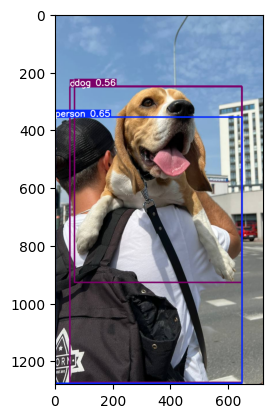

In [ ]:
image_result = results[0].plot()
image_result = cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB)

plt.imshow(image_result)

Mesmo utilizando a classe diretamente no Jupyter, podemos optar por salvar os resultados da mesma maneira como fizemos via execução por linha de comando.

In [ ]:
imagem = cv2.imread("imagens/office.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

results = model.predict(source=imagem, save=True, save_txt=True)


0: 448x640 5 persons, 1 bottle, 3 cups, 1 dining table, 5 laptops, 115.2ms
Speed: 4.2ms preprocess, 115.2ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


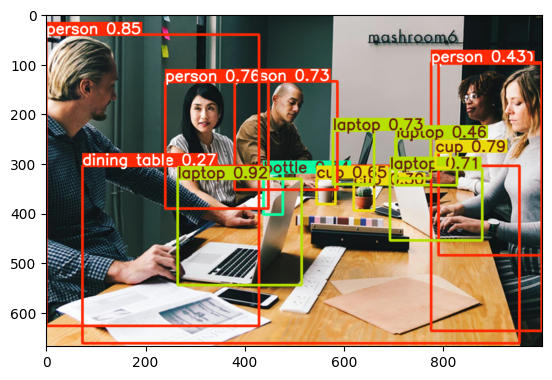

In [ ]:
image_result = results[0].plot()

plt.imshow(image_result)

### 5.2 Treinamento de modelo customizado

Para treinar o modelo YOLOv8 basta usar apenas o comando ```train```. Os parâmetros necessários para essa função são:

* configuração de um arquivo yaml com as informações de caminho das imagens e classes
* épocas
* tamanho da imagem
* nome do seu modelo

Neste exemplo vamos treinar um modelo capaz de detectar buracos em ruas e estradas.

Utilizaremos o dataset [Potholes Detection for YOLOV4](https://www.kaggle.com/datasets/anugrahakbar/potholes-detection-for-yolov4) que foi organizado no repositório abaixo.

Os datasets padrão YOLO são compatíveis com todas as versões, mesmo este dataset originalmente ter sido utilizado para a versão V4.

In [ ]:
!git clone https://github.com/michelpf/dataset-pothole

Cloning into 'dataset-pothole'...
remote: Enumerating objects: 3968, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3968 (delta 1), reused 6 (delta 0), pack-reused 3958 (from 1)
Receiving objects: 100% (3968/3968), 59.84 MiB | 16.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (3969/3969), done.


In [ ]:
!touch configs_modelo.yaml

In [ ]:
%%writefile configs_modelo.yaml
path: '/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset'
train: 'train/'
val: 'test/'

nc: 1
names: ["pothole"]

Overwriting configs_modelo.yaml


In [ ]:
arquivo_config  = "configs_modelo.yaml"

O treinamento do modelo também realiza em conjunto a validação com os dados separados do treinamento.

Ao final desta etapa é gerado diversas imagens da performance do modelo como curva F1, curva PR, curva P, curva R, matriz de confusão, dentre outras.

In [ ]:
resultados = model.train(data=arquivo_config, epochs=10, imgsz=640, name='yolov12_pothole')

Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=configs_modelo.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov12_pothole, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 137MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 227MB/s]


AMP: checks passed ✅


train: Scanning /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/train... 1562 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1562/1562 [00:00<00:00, 2128.96it/s]

train: New cache created: /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/test... 421 images, 0 backgrounds, 0 corrupt: 100%|██████████| 421/421 [00:00<00:00, 891.36it/s]


val: New cache created: /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/test.cache
Plotting labels to runs/detect/yolov12_pothole/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov12_pothole
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.34G      2.501       3.45      2.799         18        640: 100%|██████████| 98/98 [00:38<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]

                   all        421        970      0.504      0.344      0.359      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.24G      1.899      2.297      1.901         23        640: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.85it/s]

                   all        421        970      0.432       0.39      0.341      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.26G      1.752      1.906      1.724         21        640: 100%|██████████| 98/98 [00:31<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


                   all        421        970      0.568      0.455      0.472      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.28G      1.681      1.666      1.679         39        640: 100%|██████████| 98/98 [00:31<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


                   all        421        970      0.573      0.513      0.512      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.28G        1.6      1.513      1.614         17        640: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]

                   all        421        970      0.662      0.598      0.658      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.28G      1.544      1.387      1.571         17        640: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.43it/s]


                   all        421        970       0.67      0.612      0.656      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.26G      1.484      1.272      1.491         31        640: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.50it/s]

                   all        421        970      0.698      0.638      0.678      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.25G      1.452      1.208      1.469         24        640: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

                   all        421        970      0.686      0.624      0.668      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.26G      1.398      1.171      1.436         33        640: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.61it/s]

                   all        421        970      0.724      0.645      0.699      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.24G      1.372      1.107       1.41         32        640: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

                   all        421        970      0.753      0.634      0.713      0.397



10 epochs completed in 0.109 hours.
Optimizer stripped from runs/detect/yolov12_pothole/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolov12_pothole/weights/best.pt, 5.5MB

Validating runs/detect/yolov12_pothole/weights/best.pt...
Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]


                   all        421        970      0.753      0.634      0.713      0.396
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/yolov12_pothole


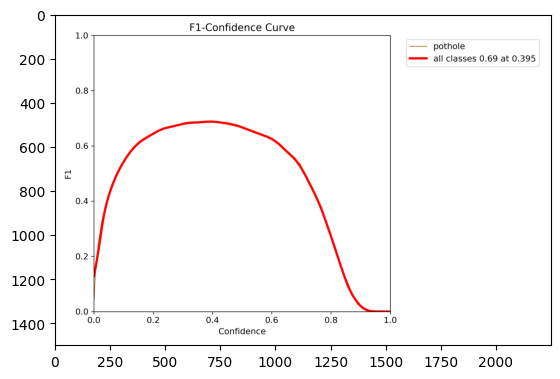

In [ ]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("runs/detect/yolov12_pothole/F1_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

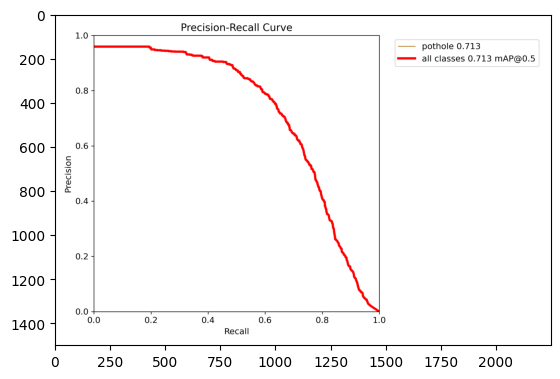

In [ ]:
image = cv2.imread("runs/detect/yolov12_pothole/PR_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

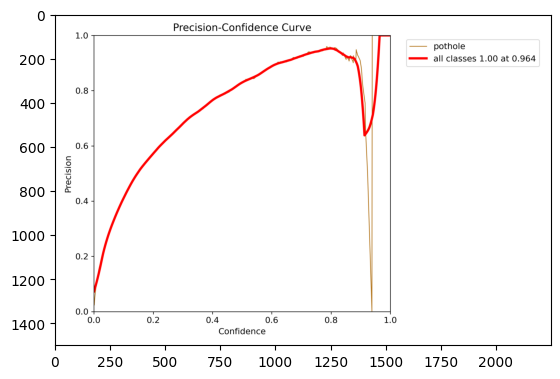

In [ ]:
image = cv2.imread("runs/detect/yolov12_pothole/P_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

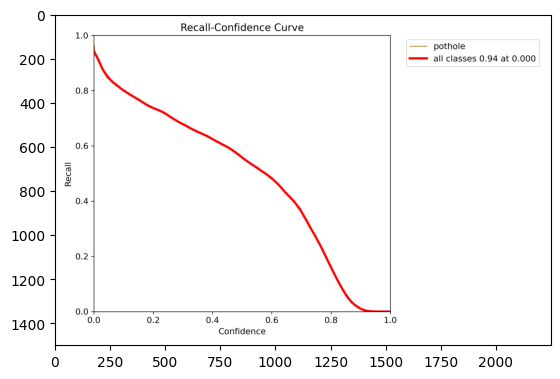

In [ ]:
image = cv2.imread("runs/detect/yolov12_pothole/R_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

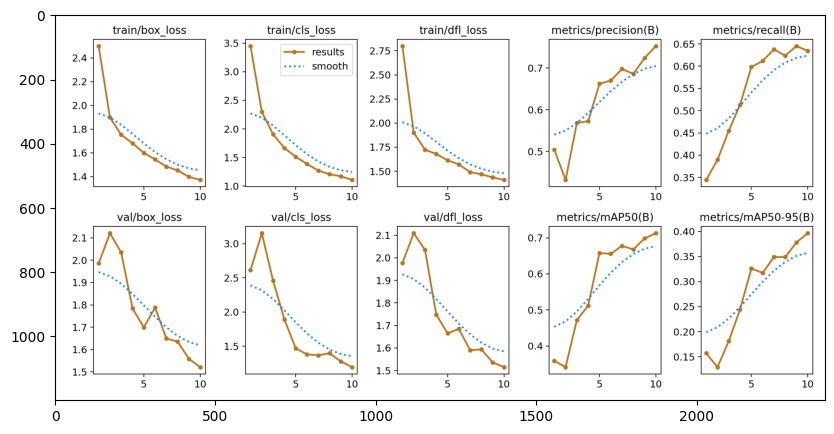

In [ ]:
image = cv2.imread("runs/detect/yolov12_pothole/results.png", cv2.IMREAD_COLOR)
plt.figure(figsize=(10,5))
plt.imshow(image)

Realizando classificações em imagens que não fizeram parte do conjunto de dados.

In [ ]:
dir_resultados = "runs/detect/yolov12_pothole/weights/best.pt"

In [ ]:
image = cv2.imread("imagens/buraco2.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
model = YOLO(dir_resultados)
results = model.predict(source=image, conf=0.25)


0: 480x640 2 potholes, 63.3ms
Speed: 3.1ms preprocess, 63.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


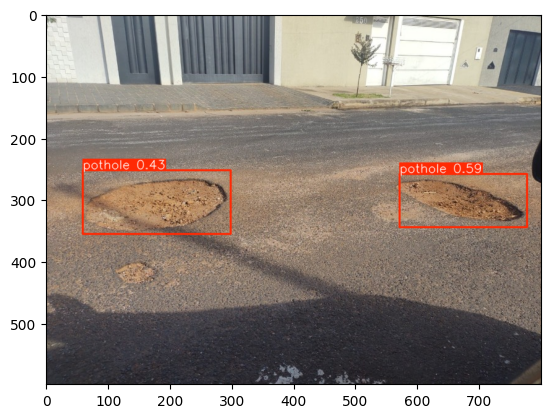

In [ ]:
image_result = results[0].plot()

plt.imshow(image_result)

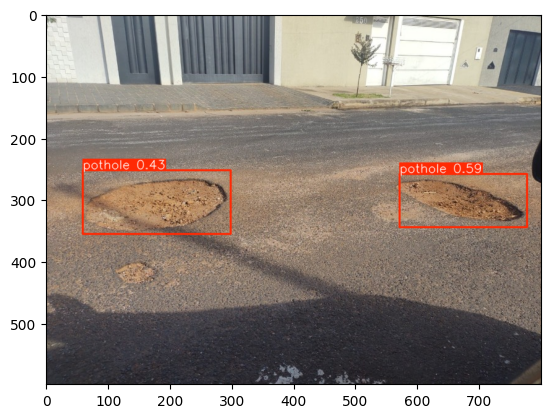

In [ ]:
image_result = results[0].plot()

plt.imshow(image_result)

In [ ]:
image = cv2.imread("imagens/buraco.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
results = model.predict(source=image, conf=0.25)


0: 448x640 1 pothole, 29.5ms
Speed: 6.3ms preprocess, 29.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


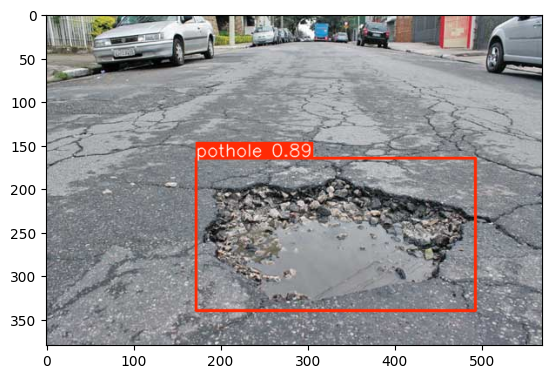

In [ ]:
image_result = results[0].plot()

plt.imshow(image_result)

In [ ]:
model.export(format='onnx')

Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/yolov12_pothole/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.3 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 282.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 327.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 250.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 264.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 254.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 16.3s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...


'runs/detect/yolov12_pothole/weights/best.onnx'

In [ ]:
# Importar bibliotecas necessárias
from ultralytics import YOLO
import cv2
import numpy as np
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt

In [ ]:
model_path = '/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/runs/detect/yolov12_pothole/weights/best.onnx'

In [ ]:
model = YOLO(model_path)

In [ ]:
# Função para exibir os resultados da detecção
def visualize_detection(image, results):
    # Obter a imagem original com as detecções desenhadas
    res_plotted = results[0].plot()

    # Converter de BGR para RGB (cv2 para matplotlib)
    res_plotted = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

    # Exibir a imagem
    plt.figure(figsize=(10, 10))
    plt.imshow(res_plotted)
    plt.axis('off')
    plt.show()

    # Imprimir os resultados
    for r in results:
        print(f"Detected {len(r.boxes)} objects:")
        # Mostrar classes e confiança
        for i, box in enumerate(r.boxes):
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            conf = float(box.conf[0])
            print(f"  {i+1}. {cls_name}: {conf:.4f}")

In [ ]:
# Inferência em uma única imagem
def predict_single_image(image_path):
    # Fazer predição
    results = model(image_path)

    # Carregar imagem para visualização
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Visualizar resultados
    visualize_detection(img, results)

    return results

In [ ]:
# Inferência em lote/batch
def predict_batch(image_folder, batch_size=16):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Processar em batches
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i+batch_size]
        results = model(batch)

        print(f"Processado lote {i//batch_size + 1}/{(len(image_paths)-1)//batch_size + 1}")

    return "Processamento em lote concluído"

In [ ]:
# Inferência em vídeo
def process_video(video_path, output_path=None):
    # Se output_path não for especificado, cria um nome padrão
    if output_path is None:
        filename = os.path.basename(video_path)
        name, ext = os.path.splitext(filename)
        output_path = f"{name}_detected{ext}"

    # Abrir o vídeo
    cap = cv2.VideoCapture(video_path)

    # Obter propriedades do vídeo
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Configurar o gravador de vídeo
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Loop pelos frames
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Processamento do frame
        results = model(frame)

        # Desenhar as detecções no frame
        annotated_frame = results[0].plot()

        # Escrever o frame processado
        out.write(annotated_frame)

        frame_count += 1
        if frame_count % 100 == 0:
            print(f"Processados {frame_count} frames")

    # Liberar recursos
    cap.release()
    out.release()

    print(f"Vídeo processado e salvo em {output_path}")
    return output_path

Loading /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/runs/detect/yolov12_pothole/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

image 1/1 /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/test/102_jpg.rf.d8bbd2c70295823660f3914725a813e7.jpg: 640x640 1 pothole, 16.5ms
Speed: 5.2ms preprocess, 16.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


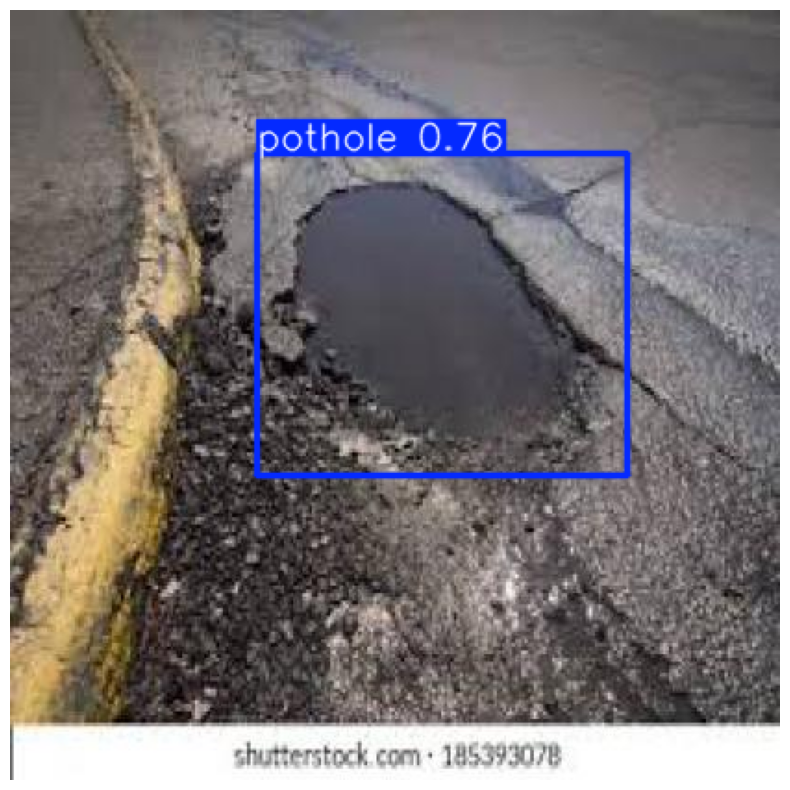

Detected 1 objects:
  1. pothole: 0.7623


In [ ]:
image_path = '/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/test/102_jpg.rf.d8bbd2c70295823660f3914725a813e7.jpg'
results = predict_single_image(image_path)

# 6. YOLO Segmentation


             🔍 Demonstração Interativa de Segmentação com YOLOv11 🤖             

Modelo carregado com sucesso!
Carregando imagem: pessoas2.jpg
Imagem carregada: 2560x1707 pixels
Processando imagem com confiança: 0.50

0: 448x640 3 persons, 2 cars, 3 motorcycles, 89.5ms
Speed: 4.4ms preprocess, 89.5ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

Classes detectadas:
   - car: 2 objeto(s)
   - motorcycle: 3 objeto(s)
   - person: 3 objeto(s)

 Visualizando resultado básico:


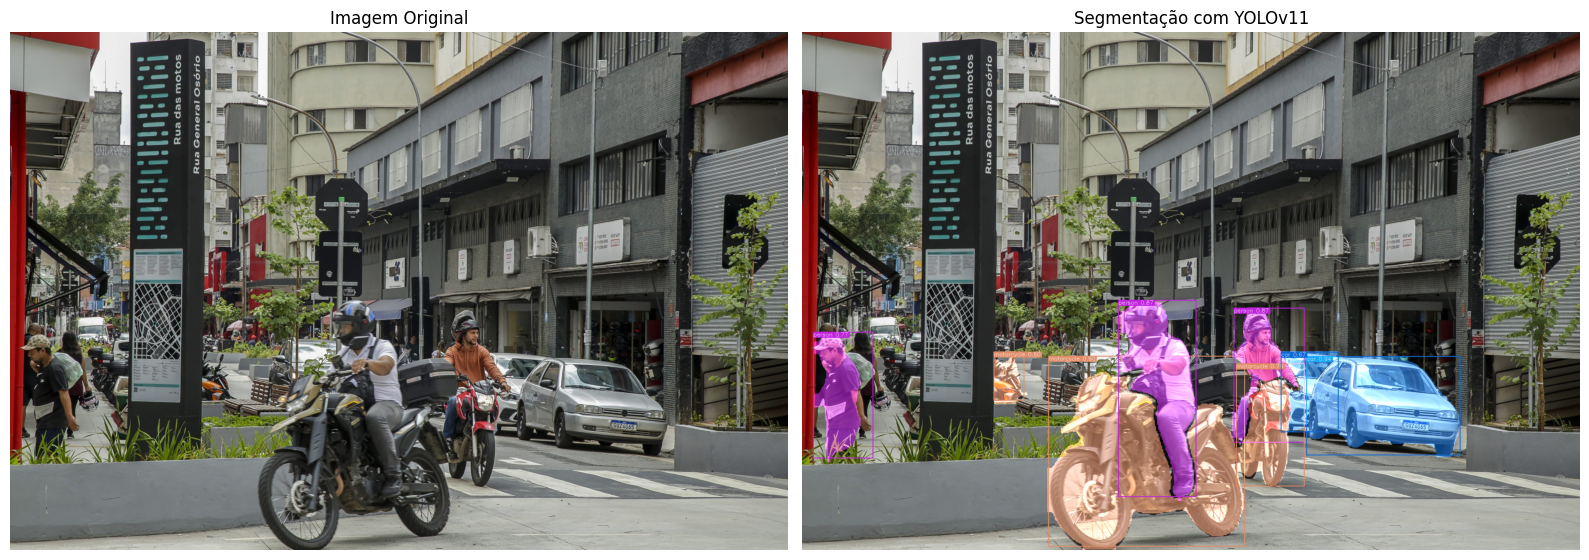


 Comparando diferentes técnicas de visão computacional:


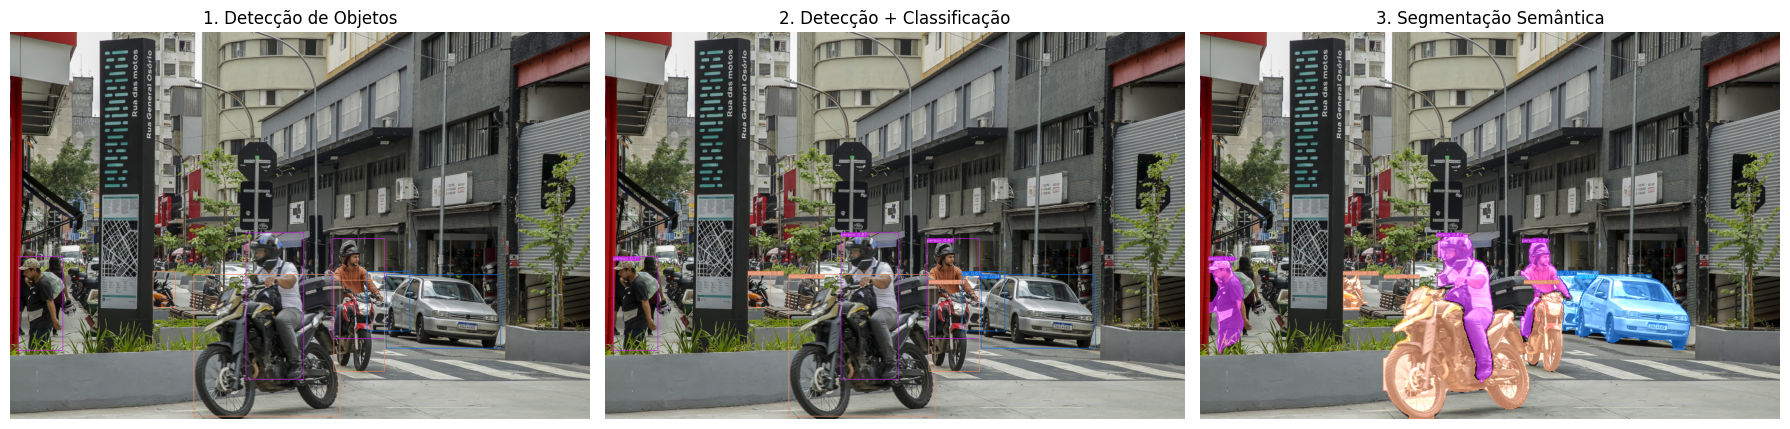


 Iniciando interface interativa para experimentação:


Output()

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from matplotlib.widgets import Button, Slider
from IPython.display import display, HTML
import ipywidgets as widgets
from PIL import Image
import io
import base64

class YOLOSegmentationDemo:
    """
    Classe para segmentação com YOLO
    """

    def __init__(self):
        """Inicializa a demonstração de segmentação com YOLO"""
        self.title = "🔍 Demonstração Interativa de Segmentação com YOLOv11 🤖"
        print(f"\n{'='*80}\n{self.title.center(80)}\n{'='*80}\n")

        # Carregar o modelo
        self.model = YOLO("yolo11x-seg.pt")
        print("Modelo carregado com sucesso!")

        # Configurações padrão
        self.conf_threshold = 0.5
        self.show_labels = True
        self.show_bbox = True
        self.overlay_opacity = 0.6
        self.image_path = None
        self.results = None
        self.original_img = None
        self.selected_classes = []
        self.detected_classes = {}  # Dicionário para armazenar classes detectadas

        # Cache para cores (consistência visual)
        self.class_colors = {}

    def get_color(self, class_id):
        """Gera ou recupera uma cor consistente para cada classe"""
        if class_id not in self.class_colors:
            self.class_colors[class_id] = [random.randint(0, 255) for _ in range(3)]
        return self.class_colors[class_id]

    def load_image(self, image_path):
        """Carrega uma imagem para processamento"""
        self.image_path = image_path
        print(f"Carregando imagem: {os.path.basename(image_path)}")
        self.original_img = cv2.imread(image_path)
        if self.original_img is None:
            raise ValueError(f"Não foi possível carregar a imagem: {image_path}")
        self.original_img = cv2.cvtColor(self.original_img, cv2.COLOR_BGR2RGB)
        print(f"Imagem carregada: {self.original_img.shape[1]}x{self.original_img.shape[0]} pixels")
        return self.original_img

    def process_image(self):
        """Processa a imagem com o modelo YOLO"""
        if self.original_img is None:
            print("Erro: Nenhuma imagem carregada.")
            return None

        print(f"Processando imagem com confiança: {self.conf_threshold:.2f}")
        self.results = self.model.predict(self.original_img, conf=self.conf_threshold)

        # Atualiza o dicionário de classes detectadas
        self.detected_classes = {}
        if len(self.results[0].boxes) > 0:
            classes = self.results[0].boxes.cls.cpu().numpy()
            for cls in classes:
                class_id = int(cls)
                class_name = self.model.names[class_id]
                if class_name in self.detected_classes:
                    self.detected_classes[class_name] += 1
                else:
                    self.detected_classes[class_name] = 1

            # Exibe estatísticas das classes detectadas
            print("\nClasses detectadas:")
            for cls_name, count in self.detected_classes.items():
                print(f"   - {cls_name}: {count} objeto(s)")

        # Se nenhuma classe específica foi selecionada, selecione todas
        if not self.selected_classes:
            self.selected_classes = list(self.detected_classes.keys())

        return self.results

    def visualize_results(self, show_original=True):
        """Visualiza os resultados da segmentação"""
        if self.results is None:
            print("Erro: Nenhum resultado para visualizar. Execute process_image() primeiro.")
            return

        # Preparar imagens para visualização
        segmented_img = self.original_img.copy()
        result = self.results[0]

        if result.masks is not None:
            masks = result.masks.xy
            boxes = result.boxes

            # Aplicar máscaras de segmentação
            for i, (mask, box) in enumerate(zip(masks, boxes)):
                class_id = int(box.cls[0])
                class_name = self.model.names[class_id]

                # Verificar se esta classe deve ser exibida
                if class_name not in self.selected_classes and self.selected_classes != ["Todas"]:
                    continue

                confidence = float(box.conf[0])
                color = self.get_color(class_id)

                # Obter coordenadas da caixa - necessário tanto para bbox quanto para labels
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                # Criar máscara
                points = np.array(mask, dtype=np.int32)
                mask_img = np.zeros_like(segmented_img)
                cv2.fillPoly(mask_img, [points], color)

                # Aplicar máscara com transparência
                segmented_img = cv2.addWeighted(
                    segmented_img, 1, mask_img, self.overlay_opacity, 0
                )

                # Desenhar caixa delimitadora
                if self.show_bbox:
                    cv2.rectangle(segmented_img, (x1, y1), (x2, y2), color, 2)

                # Adicionar rótulo
                if self.show_labels:
                    label = f"{class_name} {confidence:.2f}"
                    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
                    c2 = x1 + t_size[0] + 3, y1 + t_size[1] + 4
                    cv2.rectangle(segmented_img, (x1, y1), c2, color, -1)
                    cv2.putText(
                        segmented_img, label, (x1, y1 + t_size[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, [255, 255, 255], 1
                    )

        # Visualizar resultados
        if show_original:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

            ax1.imshow(self.original_img)
            ax1.set_title("Imagem Original")
            ax1.axis("off")

            ax2.imshow(segmented_img)
            if len(self.selected_classes) == 1 and self.selected_classes[0] != "Todas":
                ax2.set_title(f"Segmentação de: {self.selected_classes[0]}")
            else:
                ax2.set_title("Segmentação com YOLOv11")
            ax2.axis("off")

            plt.tight_layout()
            plt.show()
        else:
            plt.figure(figsize=(12, 10))
            plt.imshow(segmented_img)
            if len(self.selected_classes) == 1 and self.selected_classes[0] != "Todas":
                plt.title(f"Segmentação de: {self.selected_classes[0]}")
            else:
                plt.title("Segmentação com YOLOv11")
            plt.axis("off")
            plt.tight_layout()
            plt.show()

        return segmented_img

    def interactive_demo(self):
        """Interface interativa para demonstração em sala de aula"""
        if self.original_img is None:
            print("Erro: Carregue uma imagem primeiro usando load_image()")
            return

        # Widgets para controle interativo
        conf_slider = widgets.FloatSlider(
            value=0.5, min=0.1, max=0.9, step=0.05,
            description='Confiança:',
            layout=widgets.Layout(width='500px')
        )

        opacity_slider = widgets.FloatSlider(
            value=0.6, min=0.1, max=1.0, step=0.1,
            description='Opacidade:',
            layout=widgets.Layout(width='500px')
        )

        show_bbox_checkbox = widgets.Checkbox(
            value=True,
            description='Mostrar caixas',
            layout=widgets.Layout(width='150px')
        )

        show_labels_checkbox = widgets.Checkbox(
            value=True,
            description='Mostrar rótulos',
            layout=widgets.Layout(width='150px')
        )

        # Inicialmente, processar a imagem para detectar classes
        if self.results is None:
            self.process_image()

        # Dropdown para seleção de classes
        class_options = ["Todas"] + list(self.detected_classes.keys())
        class_dropdown = widgets.Dropdown(
            options=class_options,
            value="Todas",
            description='Classe:',
            layout=widgets.Layout(width='300px')
        )

        # Para seleção múltipla (alternativa)
        class_multiselect = widgets.SelectMultiple(
            options=list(self.detected_classes.keys()),
            value=[list(self.detected_classes.keys())[0]] if self.detected_classes else [],
            description='Classes:',
            layout=widgets.Layout(width='300px', height='100px')
        )

        # Opção para alternar entre seleção única ou múltipla
        selection_mode = widgets.RadioButtons(
            options=["Única", "Múltipla"],
            value="Única",
            description='Seleção:',
            layout=widgets.Layout(width='200px')
        )

        process_button = widgets.Button(
            description='Processar',
            button_style='primary',
            layout=widgets.Layout(width='150px')
        )

        output = widgets.Output()

        # Função que atualiza a visibilidade dos widgets de seleção
        def update_selection_widgets(_):
            if selection_mode.value == "Única":
                class_dropdown.layout.display = ''
                class_multiselect.layout.display = 'none'
            else:
                class_dropdown.layout.display = 'none'
                class_multiselect.layout.display = ''

        # Conectar a função ao widget de modo de seleção
        selection_mode.observe(update_selection_widgets, names='value')

        # Inicializar a visibilidade
        update_selection_widgets(None)

        # Função de atualização de parâmetros
        def update_params(_):
            self.conf_threshold = conf_slider.value
            self.overlay_opacity = opacity_slider.value
            self.show_bbox = show_bbox_checkbox.value
            self.show_labels = show_labels_checkbox.value

            # Atualizar classes selecionadas com base no modo de seleção
            if selection_mode.value == "Única":
                if class_dropdown.value == "Todas":
                    self.selected_classes = list(self.detected_classes.keys())
                else:
                    self.selected_classes = [class_dropdown.value]
            else:
                self.selected_classes = list(class_multiselect.value)

        # Função de processamento
        def on_process_button_clicked(_):
            update_params(_)
            with output:
                output.clear_output()
                # Se a confiança foi alterada, reprocesse a imagem
                if self.conf_threshold != conf_slider.value:
                    self.process_image()
                self.visualize_results()

        # Conectar eventos
        process_button.on_click(on_process_button_clicked)

        # Organizar layout
        selection_widgets = widgets.VBox([
            selection_mode,
            class_dropdown,
            class_multiselect
        ])

        controls = widgets.VBox([
            widgets.HBox([conf_slider, process_button]),
            widgets.HBox([opacity_slider]),
            widgets.HBox([show_bbox_checkbox, show_labels_checkbox]),
            widgets.HBox([selection_widgets])
        ])

        # Exibir UI
        display(HTML("<h3>Ajuste os parâmetros e clique em 'Processar'</h3>"))
        display(controls)
        display(output)

    def explain_segmentation(self):
        """Explica o conceito de segmentação com YOLO para a turma"""
        explanation = """
        <div style="background-color:#f8f9fa; padding:20px; border-radius:10px;">
            <h2>🔍 Como funciona a Segmentação com YOLO?</h2>

            <p>O modelo <strong>YOLOv11</strong> (You Only Look Once) realiza três tarefas principais em uma única passagem pela imagem:</p>

            <ol>
                <li><strong>Detecção de objetos</strong>: Localiza objetos com caixas delimitadoras</li>
                <li><strong>Classificação</strong>: Identifica a categoria de cada objeto</li>
                <li><strong>Segmentação</strong>: Cria uma máscara precisa que contorna o objeto</li>
            </ol>

            <h3>Vantagens da Segmentação:</h3>
            <ul>
                <li>🎯 <strong>Precisão</strong>: Contornos precisos ao invés de apenas caixas retangulares</li>
                <li>⚡ <strong>Velocidade</strong>: Rápido o suficiente para aplicações em tempo real</li>
                <li>🧩 <strong>Detalhes</strong>: Captura formas complexas e não-retangulares</li>
            </ul>

            <h3>Aplicações Práticas:</h3>
            <ul>
                <li>🚗 Direção autônoma</li>
                <li>🏥 Análise de imagens médicas</li>
                <li>🔍 Inspeção de qualidade industrial</li>
                <li>🛒 Varejo inteligente</li>
                <li>🌿 Agricultura de precisão</li>
            </ul>
        </div>
        """
        display(HTML(explanation))

    def showcase_comparison(self):
        """Mostra uma comparação entre detecção, classificação e segmentação"""
        if self.results is None:
            print("Erro: Execute process_image() primeiro para gerar resultados.")
            return

        # Preparar três versões da imagem
        detection_img = self.original_img.copy()  # Só caixas
        classification_img = self.original_img.copy()  # Caixas + rótulos
        segmentation_img = self.original_img.copy()  # Segmentação completa

        result = self.results[0]

        if result.masks is not None and len(result.boxes) > 0:
            masks = result.masks.xy
            boxes = result.boxes

            for i, (mask, box) in enumerate(zip(masks, boxes)):
                class_id = int(box.cls[0])
                class_name = self.model.names[class_id]

                # Verificar se esta classe deve ser exibida
                if self.selected_classes and class_name not in self.selected_classes and self.selected_classes != ["Todas"]:
                    continue

                confidence = float(box.conf[0])
                color = self.get_color(class_id)

                # Coordenadas da caixa
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                # 1. Só detecção (caixas)
                cv2.rectangle(detection_img, (x1, y1), (x2, y2), color, 2)

                # 2. Classificação (caixas + rótulos)
                cv2.rectangle(classification_img, (x1, y1), (x2, y2), color, 2)
                label = f"{class_name} {confidence:.2f}"
                t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
                c2 = x1 + t_size[0] + 3, y1 + t_size[1] + 4
                cv2.rectangle(classification_img, (x1, y1), c2, color, -1)
                cv2.putText(
                    classification_img, label, (x1, y1 + t_size[1]),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, [255, 255, 255], 1
                )

                # 3. Segmentação (máscaras precisas)
                points = np.array(mask, dtype=np.int32)
                mask_img = np.zeros_like(segmentation_img)
                cv2.fillPoly(mask_img, [points], color)
                segmentation_img = cv2.addWeighted(
                    segmentation_img, 1, mask_img, 0.7, 0
                )
                cv2.polylines(segmentation_img, [points], True, color, 2)

                # Adicionar rótulo na segmentação também
                cv2.rectangle(segmentation_img, (x1, y1), c2, color, -1)
                cv2.putText(
                    segmentation_img, label, (x1, y1 + t_size[1]),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, [255, 255, 255], 1
                )

        # Título adequado baseado na seleção de classes
        title_suffix = ""
        if len(self.selected_classes) == 1 and self.selected_classes[0] != "Todas":
            title_suffix = f" para '{self.selected_classes[0]}'"

        # Visualizar comparação
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(detection_img)
        axes[0].set_title(f"1. Detecção de Objetos{title_suffix}")
        axes[0].axis("off")

        axes[1].imshow(classification_img)
        axes[1].set_title(f"2. Detecção + Classificação{title_suffix}")
        axes[1].axis("off")

        axes[2].imshow(segmentation_img)
        axes[2].set_title(f"3. Segmentação Semântica{title_suffix}")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()


    def run_full_demo(self, image_path):
        """Executa uma demonstração completa para sala de aula"""

        # 1. Carregar imagem
        self.load_image(image_path)

        # 3. Processar imagem
        self.process_image()

        # 4. Visualizar resultados básicos
        print("\n Visualizando resultado básico:")
        self.visualize_results()

        # 5. Mostrar comparação de técnicas
        print("\n Comparando diferentes técnicas de visão computacional:")
        self.showcase_comparison()

        # 6. Interface interativa
        print("\n Iniciando interface interativa para experimentação:")
        self.interactive_demo()


# Exemplo de uso para sala de aula
if __name__ == "__main__":
    demo = YOLOSegmentationDemo()

    # Para Google Colab, use o caminho completo da imagem
    image_path = "/content/pessoas2.jpg"  # Substitua pelo caminho da sua imagem

    # Execute a demonstração completa
    demo.run_full_demo(image_path)


# 7.Vision Transformer

Abaixo está a implementação de um classificador de imagens baseado em transformers (Vision Transformer - ViT) utilizando PyTorch. O código está organizado em uma classe Python chamada VisionClassifier que encapsula todas as etapas necessárias para treinar e avaliar um modelo de classificação de imagens: desde o carregamento de dados até a visualização de métricas.

## Estrutura da Classe VisionClassifier

A classe VisionClassifier implementa um pipeline completo de aprendizado de máquina para visão computacional, organizado em métodos com funções específias:

1. Inicialização
```
def __init__(self, data_dir, batch_size=32, val_split=0.3, num_workers=4,
             image_size=224, seed=0, use_linformer=False):
```

O construtor da classe aceita diversos parâmetros configuráveis:

`data_dir`: Diretório contendo os dados de imagem organizados em pastas por classe

`batch_size`: Tamanho dos lotes de treinamento

`val_split`: Proporção do conjunto de dados a ser usada para validação

`image_size`: Tamanho para o qual as imagens serão redimensionadas

`use_linformer`: Flag para usar Linformer (uma versão eficiente do transformer)

2. Preparação dos Dados

```
def _setup_data(self):
```
Este método configura os datasets e dataloaders:

1. Carrega as imagens do diretório de dados
2. Identifica as classes disponíveis
3. Divide os dados em conjuntos de treinamento e validação
4. Define transformações de pré-processamento para as imagens
5. Cria dataloaders para alimentar o modelo durante o treinamento

O pré-processamento inclui:

* Redimensionamento das imagens
* Conversão para tensor
* Normalização usando valores médios da ImageNet

3. Configuração do Modelo

```
def _setup_model(self):
```

Este método configura a arquitetura do modelo:

1. Carrega um modelo Vision Transformer (ViT) pré-treinado ou cria um Linformer
2. Modifica a última camada para se adequar ao número de classes do problema
3. Configura a função de perda, otimizador e scheduler de taxa de aprendizado

## Arquitetura do Modelo

O código oferece duas opções de modelos:

### Vision Transformer (ViT)

```
# Carrega modelo ViT pré-treinado
self.modelo = timm.create_model('vit_base_patch16_224', pretrained=True)
```
O Vision Transformer divide a imagem em patches, aplica transformações lineares, e processa a sequência resultante com uma arquitetura transformer. Diferentemente das CNNs, ViTs capturam dependências globais diretamente.

### Linformer

```
# Parâmetros do Linformer
efficient_transformer = Linformer(
    dim=in_features,
    seq_len=49+1,
    depth=12,
    heads=8,
    k=64
)
```

O Linformer é uma versão mais eficiente do transformer que reduz a complexidade da atenção de O(n²) para O(n), permitindo processamento mais rápido de sequências longas.

## Pipeline de Treinamento

1. Visualização de Dados

```
def visualize_batch(self, num_rows=4, num_cols=8):
```

Este método permite visualizar um batch de imagens do conjunto de treinamento, facilitando a inspeção visual dos dados antes do treinamento.

2. Treinamento do Modelo

```
def train(self, num_epochs=15):
```

O método train implementa o loop de treinamento:

1. Para cada época:

* Realiza uma passagem pelos dados de treino (forward + backward + otimização)
* Realiza uma passagem pelos dados de validação (apenas forward)
* Registra métricas de erro e acurácia
* Salva o melhor modelo com base na acurácia de validação


3. Visualização do Progresso

```
def plot_training_history(self):
```

Este método plota gráficos de erro e acurácia ao longo das épocas, permitindo analisar o comportamento do modelo durante o treinamento:

* Convergência do treinamento
* Evidências de overfitting
* Efetividade do aprendizado

## Avaliação do Modelo

```
def evaluate(self, plot_confusion_matrix=True, plot_roc=True):
```
O método `evaluate` calcula e exibe diversas métricas de desempenho:

1. Matriz de Confusão: Mostra a distribuição das previsões corretas e incorretas para cada classe.

2. Métricas de Classificação:

* Accuracy: Proporção de previsões corretas
* Sensitivity/Recall: Taxa de positivos verdadeiros
* Specificity: Taxa de negativos verdadeiros
* Precision: Proporção de positivos previstos corretamente
* F1-Score: Média harmônica entre precision e recall
* MCC (Matthews Correlation Coefficient): Correlação entre previsões e rótulos reais

3. Curva ROC:

* Visualiza o desempenho do classificador em diferentes limiares
* Calcula a área sob a curva (AUC

## Salvar e Carregar Modelos

```
def save_model(self, filepath):
def load_model(self, filepath):
```
Estes métodos permitem:

* Salvar o modelo treinado para uso posterior
* Salvar também o histórico de treinamento e parâmetros do otimizador
* Carregar um modelo previamente treinado para inferência ou fine-tuning

---

# Bibliotecas Utilizadas

1. `vit_pytorch`

A biblioteca vit_pytorch fornece uma implementação simples e modular do Vision Transformer (ViT), uma arquitetura que aplica Transformers ao domínio de visão computacional. O ViT divide uma imagem em patches, os transforma em embeddings e os processa com camadas de Transformer para realizar tarefas de classificação.

* Funcionalidades Principais:

    * Implementação do Vision Transformer (ViT).

    * Suporte a diferentes tamanhos de patches e dimensões de embeddings.

    * Fácil integração com outros modelos e frameworks PyTorch.

* Por que usar o ViT?

  *  O ViT é uma alternativa poderosa às CNNs tradicionais, especialmente para conjuntos de dados grandes.
  
  * Ele captura dependências de longo alcance entre diferentes regiões da imagem, graças ao mecanismo de atenção do Transformer.

2. `linformer`

O linformer é uma variante eficiente do Transformer que reduz a complexidade computacional do mecanismo de atenção de O(n2)O(n2) para O(n)O(n), onde nn é o número de elementos na sequência. Isso é particularmente útil para processar imagens de alta resolução, onde o número de patches pode ser muito grande.

* Funcionalidades Principais:

  *   Implementação do Linformer, que aproxima a atenção tradicional com uma abordagem de baixa classificação.
  
  *  Redução significativa no uso de memória e tempo de computação.

  *  Integração direta com o ViT para criar modelos mais eficientes.

* Por que usar o Linformer?

    * Ideal para cenários onde a eficiência computacional é crítica.

    * Permite treinar modelos ViT em hardware com recursos limitados sem sacrificar muito a precisão.

---

# Objetivo - ViT:

O objetivo do projeto proposto é fazer o ajuste fino de um modelo de Vision Transformer Pré-Treinado. O dataset usado é baseado no: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset, cujo o conjunto de dados foi desenvolvido por uma equipe de pesquisadores da Universidade do Catar (Doha, Catar) e da Universidade de Dhaka (Bangladesh), em colaboração com pesquisadores da Malásia e médicos da Hamad Medical Corporation e de Bangladesh. O objetivo do banco de dados é fornecer imagens de radiografia torácica para auxiliar na detecção da tuberculose (TB), contendo tanto casos positivos quanto imagens normais.

Atualmente, o conjunto de dados inclui:
- **700** imagens de radiografias de tórax com TB acessíveis ao público.
- **2800** imagens adicionais de TB disponíveis para download no portal da [NIAID TB](https://www.niaid.nih.gov/) mediante assinatura de um contrato.
- **3500** imagens de radiografias normais.


In [ ]:
!pip install linformer vit_pytorch timm

In [ ]:
import os
import copy
import math
import torch
import timm
import torchvision
import pandas as pd
import numpy as np
from tqdm import tqdm

from linformer import Linformer
from vit_pytorch.efficient import ViT

from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from torch import optim, nn
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [ ]:
class VisionClassifier:
    def __init__(self, data_dir, batch_size=32, val_split=0.3, num_workers=4,
                 image_size=224, seed=0, use_linformer=False):
        """
        Inicializa o classificador de imagens.

        Args:
            data_dir (str): Diretório com as imagens organizadas em pastas por classe
            batch_size (int): Tamanho do batch para treinamento
            val_split (float): Proporção dos dados para validação (0-1)
            num_workers (int): Número de workers para o DataLoader
            image_size (int): Tamanho das imagens para redimensionamento
            seed (int): Semente para reprodutibilidade
            use_linformer (bool): Se True, usa Linformer em vez do modelo ViT padrão
        """
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.num_workers = num_workers
        self.image_size = image_size
        self.seed = seed
        self.use_linformer = use_linformer
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Histórico de treinamento
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_loss_history = []
        self.val_acc_history = []
        self.best_acc = 0.0

        # Inicialização dos dados e modelo
        self._setup_data()
        self._setup_model()

    def _setup_data(self):
        """Configura os datasets e dataloaders para treinamento e validação"""
        # Dataset completo
        self.dataset_completo = datasets.ImageFolder(self.data_dir)
        self.class_names = self.dataset_completo.classes
        print(f"Dataset carregado: {self.dataset_completo}")
        print(f"Classes: {self.class_names}")

        # Divide em treino e validação
        full_size = len(self.dataset_completo)
        train_size = int((1 - self.val_split) * full_size)
        val_size = full_size - train_size

        torch.manual_seed(self.seed)
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            self.dataset_completo, [train_size, val_size])

        # Tamanhos dos datasets
        self.dataset_sizes = {'train': len(self.train_dataset), 'val': len(self.val_dataset)}
        print(f"Tamanhos dos datasets: {self.dataset_sizes}")

        # Transformações para os dados
        self.data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

        # Aplica transformações
        self.train_dataset.dataset.transform = self.data_transforms['train']

        # Cria dataloaders
        self.train_dataloader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

        self.val_dataloader = torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

        # Dicionário de dataloaders
        self.dataloaders = {'train': self.train_dataloader, 'val': self.val_dataloader}

    def _setup_model(self):
        """Configura o modelo de classificação"""
        if self.use_linformer:
            # Parâmetros do Linformer
            in_features = 128
            efficient_transformer = Linformer(
                dim=in_features,
                seq_len=49+1,  # 49 patches + 1 para o token de classificação
                depth=12,
                heads=8,
                k=64
            )

            # Cria o modelo ViT com Linformer
            self.modelo = ViT(
                dim=in_features,
                image_size=self.image_size,
                patch_size=32,
                num_classes=2,
                transformer=efficient_transformer,
                channels=3
            )

            num_ftrs = in_features
        else:
            # Carrega modelo ViT pré-treinado
            self.modelo = timm.create_model('vit_base_patch16_224', pretrained=True)
            num_ftrs = self.modelo.head.in_features

        # Modifica a última camada para a tarefa de classificação
        self.modelo.head = nn.Linear(num_ftrs, len(self.class_names))

        # Envia o modelo para o device
        self.modelo = self.modelo.to(self.device)

        # Calcula o número de parâmetros do modelo
        model_parameters = filter(lambda p: p.requires_grad, self.modelo.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print(f'Número de parâmetros: {params}')

        # Função de erro e otimizador
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.modelo.parameters(), lr=3e-5)
        self.scheduler = StepLR(self.optimizer, step_size=7, gamma=0.1)

    def visualize_batch(self, num_rows=4, num_cols=8):
        """
        Visualiza um batch de imagens do conjunto de treinamento.

        Args:
            num_rows (int): Número de linhas para a visualização
            num_cols (int): Número de colunas para a visualização
        """
        # Obtém um batch de dados de treino
        inputs, labels = next(iter(self.train_dataloader))
        # Converte o batch em tensores numpy
        inputs = inputs.numpy()
        labels = labels.numpy()

        # Nomes das categorias
        label_names = [self.class_names[label] for label in labels]

        # Visualiza imagens e labels
        fig, axes = plt.subplots(figsize=(12, 8), nrows=num_rows, ncols=num_cols)
        axes = axes.flatten()

        # Loop para exibir as imagens
        for i, (image, label) in enumerate(zip(inputs, label_names)):
            if i >= len(axes):
                break

            image = np.transpose(image, (1, 2, 0))
            image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            image = np.clip(image, 0, 1)
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(label)

        plt.tight_layout()
        plt.show()

    def train(self, num_epochs=15):
        """
        Treina o modelo.

        Args:
            num_epochs (int): Número de épocas para treinamento

        Returns:
            dict: Histórico de treinamento
        """
        # Zera os históricos de treinamento
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_loss_history = []
        self.val_acc_history = []
        self.best_acc = 0.0

        # Salva os melhores pesos do modelo
        best_model_wts = copy.deepcopy(self.modelo.state_dict())

        # Loop de treinamento
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Define qual fase estamos, treino ou validação
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.modelo.train()
                else:
                    self.modelo.eval()

                # Contadores
                running_loss = 0.0
                running_corrects = 0

                # Usa tqdm para mostrar o progresso
                dataloader = self.dataloaders[phase]
                with tqdm(dataloader, unit="batch") as tepoch:
                    for inputs, labels in tepoch:
                        tepoch.set_description(f"Epoch {epoch} {phase}")

                        # Envia imagens e labels para o device
                        inputs = inputs.to(self.device)
                        labels = labels.to(self.device)

                        # Zera os gradientes
                        self.optimizer.zero_grad()

                        # Forward propagation
                        with torch.set_grad_enabled(phase == 'train'):
                            # Faz as previsões com o modelo
                            outputs = self.modelo(inputs)

                            # Obtém a maior probabilidade de classe
                            _, preds = torch.max(outputs, 1)

                            # Calcula o erro
                            loss = self.criterion(outputs, labels)

                            # Backpropagation e otimização somente em treino
                            if phase == 'train':
                                loss.backward()
                                self.optimizer.step()

                        # Calcula estatísticas
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)

                        # Atualiza a barra de progresso com o loss atual
                        tepoch.set_postfix(loss=loss.item())

                # Calcula erro e acurácia
                epoch_loss = running_loss / self.dataset_sizes[phase]
                epoch_acc = (running_corrects.double() / self.dataset_sizes[phase]).item()

                # Grava o histórico
                if phase == 'train':
                    self.train_loss_history.append(epoch_loss)
                    self.train_acc_history.append(epoch_acc)
                else:
                    self.val_loss_history.append(epoch_loss)
                    self.val_acc_history.append(epoch_acc)

                print(f'{phase} - Erro: {epoch_loss:.4f} Acurácia: {epoch_acc:.4f}')

                # Deep copy do modelo
                if phase == 'val' and epoch_acc > self.best_acc:
                    self.best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.modelo.state_dict())

            print()

        print(f'\nMelhor Acurácia em Validação: {self.best_acc:4f}')
        print('\nTreinamento Concluído')

        # Carrega os melhores pesos do modelo
        self.modelo.load_state_dict(best_model_wts)

        return {
            'train_loss': self.train_loss_history,
            'train_acc': self.train_acc_history,
            'val_loss': self.val_loss_history,
            'val_acc': self.val_acc_history,
            'best_acc': self.best_acc
        }

    def plot_training_history(self):
        """Plota o histórico de treinamento (erro e acurácia)"""
        # Verifica se há dados de treinamento
        if not self.train_loss_history:
            print("Não há histórico de treinamento. Execute o método 'train' primeiro.")
            return

        # Época
        epoch = range(1, len(self.train_loss_history) + 1)

        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].plot(epoch, self.train_loss_history, label='Erro em Treino')
        ax[0].plot(epoch, self.val_loss_history, label='Erro em Validação')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Erro')
        ax[0].legend()

        ax[1].plot(epoch, self.train_acc_history, label='Acurácia em Treino')
        ax[1].plot(epoch, self.val_acc_history, label='Acurácia em Validação')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Acurácia')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

    def evaluate(self, plot_confusion_matrix=True, plot_roc=True):
        """
        Avalia o modelo no conjunto de validação.

        Args:
            plot_confusion_matrix (bool): Se True, plota a matriz de confusão
            plot_roc (bool): Se True, plota a curva ROC

        Returns:
            dict: Métricas de avaliação
        """
        # Obtém labels reais e previsões
        true_labels, pred_labels, pred_probs = self._get_predictions(self.dataloaders['val'])

        # Calcula a confusion matrix
        cm_val = confusion_matrix(true_labels, pred_labels)
        a_val = cm_val[0, 0]  # Verdadeiro Negativo
        b_val = cm_val[0, 1]  # Falso Positivo
        c_val = cm_val[1, 0]  # Falso Negativo
        d_val = cm_val[1, 1]  # Verdadeiro Positivo

        # Calcula métricas
        acc_val = (a_val + d_val) / (a_val + b_val + c_val + d_val)  # Acurácia
        error_rate_val = 1 - acc_val  # Taxa de erro
        sen_val = d_val / (d_val + c_val) if (d_val + c_val) > 0 else 0  # Sensibilidade
        spec_val = a_val / (a_val + b_val) if (a_val + b_val) > 0 else 0  # Especificidade
        precision_val = d_val / (b_val + d_val) if (b_val + d_val) > 0 else 0  # Precisão

        # F1 score
        if (precision_val + sen_val) > 0:
            f1_val = (2 * precision_val * sen_val) / (precision_val + sen_val)
        else:
            f1_val = 0

        # Coeficiente de Correlação de Matthews
        mcc_denominator = np.sqrt((d_val + b_val) * (d_val + c_val) * (a_val + b_val) * (a_val + c_val))
        if mcc_denominator > 0:
            mcc_val = (d_val * a_val - b_val * c_val) / mcc_denominator
        else:
            mcc_val = 0

        # AUC score (para problemas binários)
        if len(self.class_names) == 2 and pred_probs is not None:
            auc_score_val = metrics.roc_auc_score(true_labels, pred_probs)
        else:
            auc_score_val = None

        # Exibe as métricas
        print("\n Sensitivity em validação:", sen_val,
              "\n Specificity em validação:", spec_val,
              "\n Accuracy em validação:", acc_val,
              "\n Error rate em validação:", error_rate_val,
              "\n Precision em validação:", precision_val,
              "\n F1 score em validação:", f1_val,
              "\n Matthews Correlation Coefficient (MCC) em validação:", mcc_val)

        if auc_score_val is not None:
            print("O valor AUC para o conjunto de validação é:", auc_score_val)

        # Plota a matriz de confusão
        if plot_confusion_matrix:
            self._plot_confusion_matrix(true_labels, pred_labels)

        # Plota a curva ROC (apenas para classificação binária)
        if plot_roc and auc_score_val is not None:
            self._plot_roc_curve("AUC em Validação: {0:.4f}".format(auc_score_val),
                                true_labels, pred_probs)

        # Retorna as métricas
        metrics_dict = {
            'accuracy': acc_val,
            'error_rate': error_rate_val,
            'sensitivity': sen_val,
            'specificity': spec_val,
            'precision': precision_val,
            'f1_score': f1_val,
            'mcc': mcc_val,
            'auc': auc_score_val
        }

        return metrics_dict

    def _get_predictions(self, dataloader):
        """
        Obtém as previsões do modelo para um dataloader.

        Args:
            dataloader (DataLoader): DataLoader com os dados para previsão

        Returns:
            tuple: (labels reais, labels previstas, probabilidades previstas)
        """
        # Coloca o modelo em modo de avaliação
        self.modelo.eval()

        # Listas
        true_labels = []
        pred_labels = []
        pred_probs = [] if len(self.class_names) == 2 else None

        # Faz as previsões a partir dos dados
        for inputs, labels in dataloader:
            # Envia imagens e labels para o device
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            # Forward
            with torch.no_grad():
                outputs = self.modelo(inputs)
                _, preds = torch.max(outputs, 1)

                # Para classificação binária, armazena a probabilidade da classe positiva
                if len(self.class_names) == 2:
                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    pred_probs.extend(probs[:, 1].cpu().numpy())

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

        return true_labels, pred_labels, pred_probs

    def _plot_confusion_matrix(self, true_labels, pred_labels):
        """
        Plota a matriz de confusão.

        Args:
            true_labels (list): Lista de labels reais
            pred_labels (list): Lista de labels previstas
        """
        conf_numpy = confusion_matrix(true_labels, pred_labels)
        conf_df = pd.DataFrame(conf_numpy, index=self.class_names, columns=self.class_names)
        plt.figure(figsize=(8, 7))
        sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
        plt.title('Confusion Matrix', fontsize=15)
        plt.ylabel('Valor Real', fontsize=14)
        plt.xlabel('Valor Previsto', fontsize=14)
        plt.show()

    def _plot_roc_curve(self, name, labels, predictions, **kwargs):
        """
        Plota a curva ROC.

        Args:
            name (str): Nome para a legenda
            labels (list): Lista de labels reais
            predictions (list): Lista de probabilidades previstas
            **kwargs: Argumentos adicionais para o plot
        """
        fp, tp, _ = metrics.roc_curve(labels, predictions)
        plt.figure(figsize=(8, 6))
        plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
        plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
        plt.xlabel('Taxa de Falso Positivo')
        plt.ylabel('Taxa de Verdadeiro Positivo')
        plt.title('Curva ROC', fontsize=15)
        plt.legend(loc='lower right')
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.show()

    def save_model(self, filepath):
        """
        Salva o modelo treinado.

        Args:
            filepath (str): Caminho para salvar o modelo
        """
        torch.save({
            'model_state_dict': self.modelo.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'class_names': self.class_names,
            'training_history': {
                'train_loss': self.train_loss_history,
                'train_acc': self.train_acc_history,
                'val_loss': self.val_loss_history,
                'val_acc': self.val_acc_history,
                'best_acc': self.best_acc
            }
        }, filepath)
        print(f"Modelo salvo em {filepath}")

    def load_model(self, filepath):
        """
        Carrega um modelo treinado.

        Args:
            filepath (str): Caminho do modelo salvo
        """
        checkpoint = torch.load(filepath)
        self.modelo.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.class_names = checkpoint['class_names']

        # Carrega o histórico de treinamento, se disponível
        if 'training_history' in checkpoint:
            history = checkpoint['training_history']
            self.train_loss_history = history['train_loss']
            self.train_acc_history = history['train_acc']
            self.val_loss_history = history['val_loss']
            self.val_acc_history = history['val_acc']
            self.best_acc = history['best_acc']

        print(f"Modelo carregado de {filepath}")

In [ ]:
# Instanciar o classificador
classifier = VisionClassifier(data_dir="dados", batch_size=32, val_split=0.3)


Dataset carregado: Dataset ImageFolder
    Number of datapoints: 1600
    Root location: dados
Classes: ['Normal', 'Tuberculosis']
Tamanhos dos datasets: {'train': 1120, 'val': 480}
Número de parâmetros: 85800194


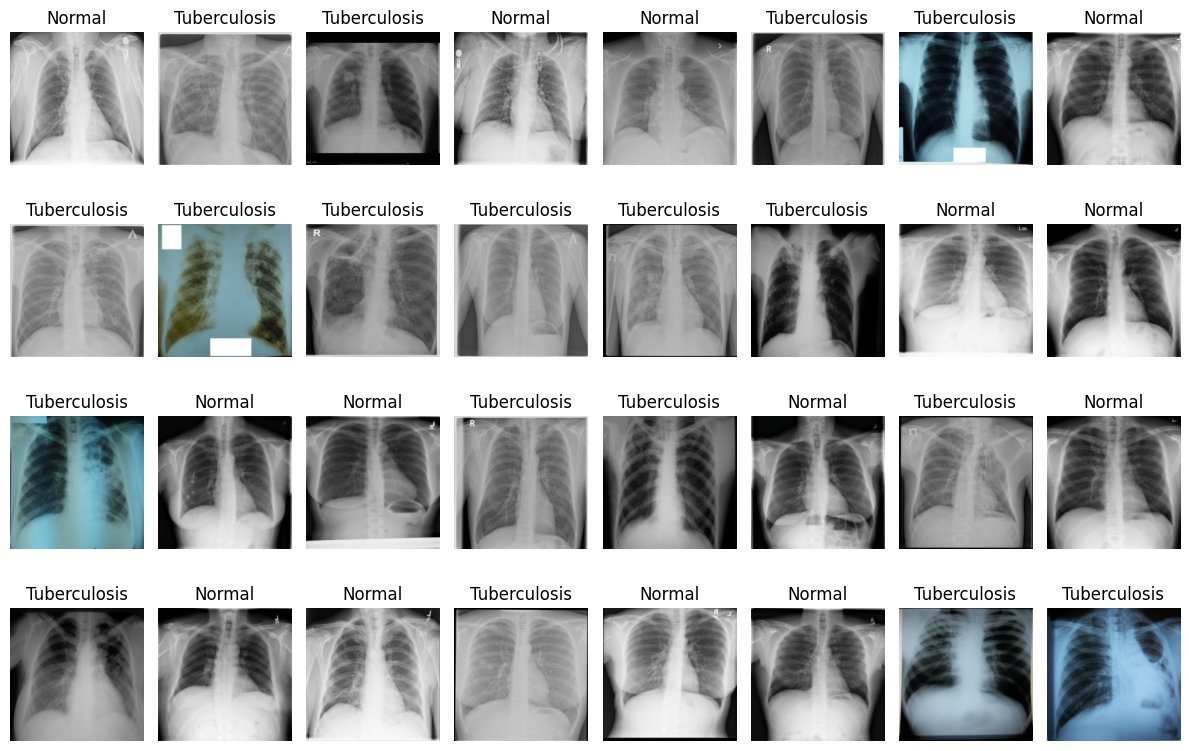

In [ ]:
# Visualizar um batch de imagens
classifier.visualize_batch()


In [ ]:
# Treinar o modelo
history = classifier.train(num_epochs=15)

Epoch 0/14
----------


Epoch 0 train: 100%|██████████| 35/35 [00:37<00:00,  1.08s/batch, loss=0.0146]


train - Erro: 0.1267 Acurácia: 0.9402


Epoch 0 val: 100%|██████████| 15/15 [00:07<00:00,  2.14batch/s, loss=0.0099]


val - Erro: 0.0393 Acurácia: 0.9896

Epoch 1/14
----------


Epoch 1 train: 100%|██████████| 35/35 [00:39<00:00,  1.12s/batch, loss=0.00142]


train - Erro: 0.0259 Acurácia: 0.9929


Epoch 1 val: 100%|██████████| 15/15 [00:07<00:00,  2.07batch/s, loss=0.00821]


val - Erro: 0.0189 Acurácia: 0.9938

Epoch 2/14
----------


Epoch 2 train: 100%|██████████| 35/35 [00:39<00:00,  1.12s/batch, loss=1.2e-5]


train - Erro: 0.0018 Acurácia: 1.0000


Epoch 2 val: 100%|██████████| 15/15 [00:08<00:00,  1.77batch/s, loss=0.00633]


val - Erro: 0.0166 Acurácia: 0.9958

Epoch 3/14
----------


Epoch 3 train: 100%|██████████| 35/35 [00:38<00:00,  1.11s/batch, loss=9.5e-6]


train - Erro: 0.0011 Acurácia: 0.9991


Epoch 3 val: 100%|██████████| 15/15 [00:07<00:00,  1.95batch/s, loss=4.72e-5]


val - Erro: 0.0192 Acurácia: 0.9958

Epoch 4/14
----------


Epoch 4 train: 100%|██████████| 35/35 [00:38<00:00,  1.11s/batch, loss=1.27e-5]


train - Erro: 0.0001 Acurácia: 1.0000


Epoch 4 val: 100%|██████████| 15/15 [00:07<00:00,  2.02batch/s, loss=1.66e-5]


val - Erro: 0.0240 Acurácia: 0.9958

Epoch 5/14
----------


Epoch 5 train: 100%|██████████| 35/35 [00:39<00:00,  1.12s/batch, loss=5.11e-6]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 5 val: 100%|██████████| 15/15 [00:08<00:00,  1.80batch/s, loss=7.36e-5]


val - Erro: 0.0230 Acurácia: 0.9958

Epoch 6/14
----------


Epoch 6 train: 100%|██████████| 35/35 [00:38<00:00,  1.09s/batch, loss=8.72e-6]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 6 val: 100%|██████████| 15/15 [00:06<00:00,  2.19batch/s, loss=2.62e-5]


val - Erro: 0.0230 Acurácia: 0.9958

Epoch 7/14
----------


Epoch 7 train: 100%|██████████| 35/35 [00:38<00:00,  1.10s/batch, loss=1.97e-6]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 7 val: 100%|██████████| 15/15 [00:07<00:00,  2.10batch/s, loss=0.00249]


val - Erro: 0.0234 Acurácia: 0.9958

Epoch 8/14
----------


Epoch 8 train: 100%|██████████| 35/35 [00:37<00:00,  1.08s/batch, loss=3.66e-6]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 8 val: 100%|██████████| 15/15 [00:06<00:00,  2.16batch/s, loss=8.63e-5]


val - Erro: 0.0237 Acurácia: 0.9958

Epoch 9/14
----------


Epoch 9 train: 100%|██████████| 35/35 [00:37<00:00,  1.07s/batch, loss=3.3e-5]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 9 val: 100%|██████████| 15/15 [00:06<00:00,  2.24batch/s, loss=0.00184]


val - Erro: 0.0248 Acurácia: 0.9958

Epoch 10/14
----------


Epoch 10 train: 100%|██████████| 35/35 [00:38<00:00,  1.09s/batch, loss=2.68e-7]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 10 val: 100%|██████████| 15/15 [00:07<00:00,  2.09batch/s, loss=1.59e-5]


val - Erro: 0.0250 Acurácia: 0.9958

Epoch 11/14
----------


Epoch 11 train: 100%|██████████| 35/35 [00:37<00:00,  1.08s/batch, loss=3.63e-6]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 11 val: 100%|██████████| 15/15 [00:06<00:00,  2.24batch/s, loss=7.39e-5]


val - Erro: 0.0254 Acurácia: 0.9958

Epoch 12/14
----------


Epoch 12 train: 100%|██████████| 35/35 [00:38<00:00,  1.11s/batch, loss=2.06e-6]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 12 val: 100%|██████████| 15/15 [00:06<00:00,  2.18batch/s, loss=5.94e-5]


val - Erro: 0.0256 Acurácia: 0.9958

Epoch 13/14
----------


Epoch 13 train: 100%|██████████| 35/35 [00:37<00:00,  1.08s/batch, loss=2.76e-7]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 13 val: 100%|██████████| 15/15 [00:06<00:00,  2.17batch/s, loss=4.32e-5]


val - Erro: 0.0256 Acurácia: 0.9958

Epoch 14/14
----------


Epoch 14 train: 100%|██████████| 35/35 [00:37<00:00,  1.08s/batch, loss=3.08e-6]


train - Erro: 0.0000 Acurácia: 1.0000


Epoch 14 val: 100%|██████████| 15/15 [00:06<00:00,  2.25batch/s, loss=0.194]

val - Erro: 0.0259 Acurácia: 0.9958


Melhor Acurácia em Validação: 0.995833

Treinamento Concluído


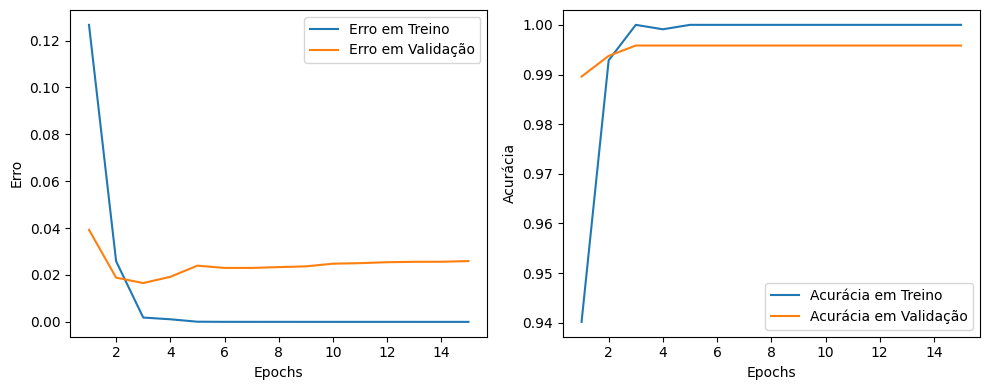

In [ ]:
# Visualizar o histórico de treinamento
classifier.plot_training_history()


 Sensitivity em validação: 0.9898477157360406 
 Specificity em validação: 1.0 
 Accuracy em validação: 0.9958333333333333 
 Error rate em validação: 0.004166666666666652 
 Precision em validação: 1.0 
 F1 score em validação: 0.9948979591836734 
 Matthews Correlation Coefficient (MCC) em validação: 0.9914138469763721
O valor AUC para o conjunto de validação é: 0.9998206310200713


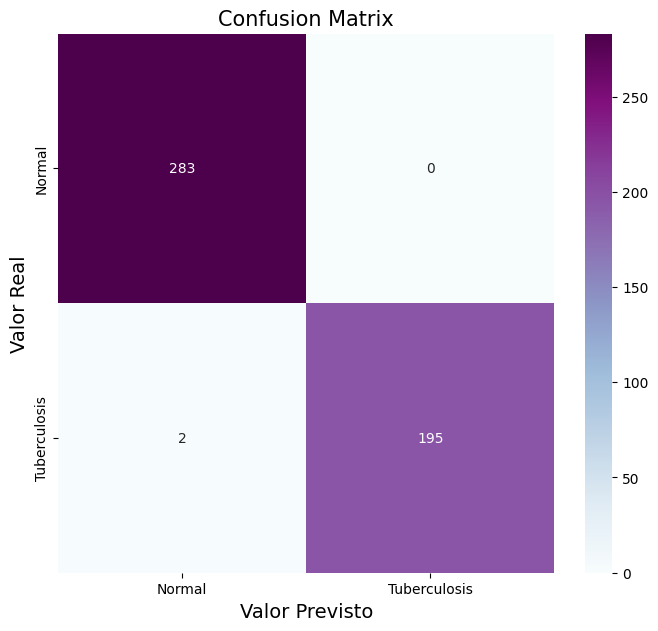

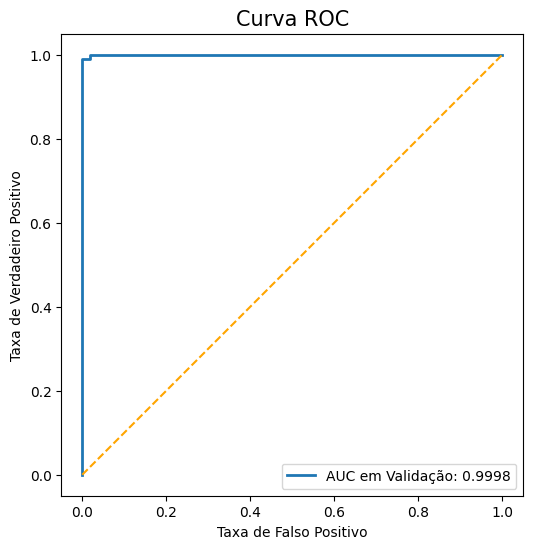

In [ ]:
# Avaliar o modelo
metrics = classifier.evaluate()


In [ ]:
# Salvar o modelo treinado
classifier.save_model("modelo_visao_computacional.pth")

Modelo salvo em modelo_visao_computacional.pth
